In [1]:
from typing import List, Optional
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

from IPython.display import display, Markdown

In [2]:
import pickle

with open("./results/pretraining.pkl", "rb") as f:
    results = pickle.load(f)
runs_df = results["runs_df"]
no_dp_results = results["no_dp_results"]

In [3]:
# import pandas as pd 
# from tqdm import tqdm
# import wandb

# ARCHIVE_SWEEP_IDS = {}

# api = wandb.Api(timeout=60)

# # Project is specified by <entity/project-name>
# runs = api.runs("shlomihod/ydnpd-dp-ft",
#                 filters={"created_at": {"$gte": "2025-02-03T00:00:00.000000+00:00"}},
#                 # per_page=3_000
#                 )
# run_records = []

# for run in tqdm(runs):

#     run_records.append({
#         "id_": run.id,
#         "summary": run.summary._json_dict,
#         "config": {k: v for k,v in run.config.items()
#           if not k.startswith('_')},
#         "name": run.name,
#         "sweep": run.sweep.id,
#     })

# runs_df = pd.DataFrame(run_records)

# for col in ("summary", "config"):
#     runs_df = runs_df.join(pd.json_normalize(runs_df[col]))

# def extract_public_data_pointer(r):
#     if not r['public_data_pointer']:
#         family, _ = r['private_data_pointer'].split("/")
#         return f"{family}/no-pre"
#     elif isinstance(r['public_data_pointer'], list):
#         return r['public_data_pointer'][0]
#     else:
#         return r['public_data_pointer']

# runs_df['public_data_pointer'] = runs_df.apply(extract_public_data_pointer, axis=1)

# # runs_df.loc[
# #     runs_df['public_data_pointer'].str.endswith("no-pre"),
# #     'dp/private.test/auc'
# #     ] = runs_df.loc[runs_df['public_data_pointer'].str.endswith("no-pre"), 'dp.test/auc']

In [4]:
runs_df['public_data_pointer'].value_counts()

public_data_pointer
edad/2020                      800
we/gen-claude-MIX-MAX          800
we/gen-claude-MIX-UNIF         800
we/gen-MIX-UNIF                800
we/gen-llama-MIX-UNIF          800
we/sdscm-llama-3-8b            800
we/csv-llama                   800
acs/massachusetts_upsampled    800
acs/baseline_univariate        800
acs/baseline_domain            800
acs/arbitrary                  800
acs/gen-MIX-MAX                800
acs/csv-gpt                    800
acs/gen-gpt-MIX-MAX            800
acs/sdscm-gpt2                 800
acs/gen-llama-MIX-MAX          800
acs/sdscm-olmo-1b-hf           800
acs/gen-gpt-MIX-UNIF           800
acs/gen-claude-MIX-MAX         800
acs/csv-claude                 800
acs/gen-claude-MIX-UNIF        800
acs/gen-MIX-UNIF               800
acs/gen-llama-MIX-UNIF         800
acs/sdscm-llama-3-8b           800
acs/csv-llama                  800
edad/baseline_univariate       800
we/csv-claude                  800
we/gen-gpt-MIX-UNIF            800


In [5]:
runs_without_gpt2_df = runs_df.loc[~runs_df['public_data_pointer'].str.contains("gpt2")]

In [6]:
# Define the pre-training hyperparameter columns order
pre_hparam_cols = [col for col in runs_df.columns if col.startswith("pre_")]

# Calculate mean performance for each hyperparameter configuration
avg_performance = (
    runs_df.groupby(["epsilon", "public_data_pointer"] + pre_hparam_cols)
    ["pre/public.test/auc"]
    .mean()
)

# Get the hyperparameter configurations that achieve the best mean performance
best_pre_hparams = avg_performance.groupby(level=["epsilon", "public_data_pointer"]).idxmax()

# Get indices of all runs matching the best configurations
idx = []
for (eps, pdp), pre_hparams in best_pre_hparams.items():
    # First ensure epsilon and public_data_pointer match
    mask = (runs_df['epsilon'] == eps) & (runs_df['public_data_pointer'] == pdp)
    
    # Then match all hyperparameters - using only the hyperparameter values (last 3 values)
    for col, val in zip(pre_hparam_cols, pre_hparams[-3:]):  # Take last 3 values which are the actual hyperparameters
        mask &= (runs_df[col] == val)
    
    idx.extend(runs_df[mask].index)

# Assert we have only one config per (epsilon, pdp)
config_counts = runs_df.loc[idx].groupby(["epsilon", "public_data_pointer"])[pre_hparam_cols].nunique()
assert (config_counts == 1).all().all(), "Found multiple hyperparameter configurations for some (epsilon, pdp) pairs"

# Create final dataframe
runs_best_on_pre_df = pd.concat([
    runs_df.loc[idx].reset_index(drop=True),
    runs_df.loc[runs_df["public_data_pointer"].str.contains("no-pre")]
])


runs_best_on_pre_without_gpt2_df = runs_best_on_pre_df.loc[~runs_best_on_pre_df['public_data_pointer'].str.contains("gpt2")]
runs_best_on_pre_df["private_data_pointer"].value_counts()

private_data_pointer
acs/national    1900
we/2023         1900
edad/2023       1600
Name: count, dtype: int64

In [7]:
# from ydnpd.pretraining.trainer import TransformerTrainer

# no_dp_results = {pointer.split("/")[0]: [
#     TransformerTrainer.train_and_evaluate(public_data_pointer=pointer)["no-dp"]
#     for _ in range(80)]
#     for pointer in runs_df['private_data_pointer'].unique()}

In [8]:
# import pickle
# with open("./results/pretraining.pkl", "wb") as f:
#     pickle.dump({"runs_df": runs_df, "no_dp_results": no_dp_results}, f)

In [9]:
plt.style.use(['science', 'no-latex'])


PUBLIC_DATASETS = ["acs/massachusetts_upsampled", "edad/2020", "we/2018"]
CATEGORY_ORDER = ["Without pretraining", "Public", "Baseline", "Arbitrary", "CSV", "Agent", "SD-SCM"]


def validate_dataframe(df: pd.DataFrame) -> None:
    """
    Validate the input DataFrame has required columns and format.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to validate
    
    Raises
    ------
    ValueError
        If DataFrame doesn't meet requirements
    """
    if 'category' not in df.columns:
        raise ValueError("DataFrame must contain 'category' column")
    
    # Check for epsilon columns
    eps_cols = [col for col in df.columns if col.startswith('eps=')]
    if not eps_cols:
        raise ValueError("DataFrame must contain epsilon columns (format: 'eps=X')")
    
    # Verify epsilon columns contain numeric data
    for col in eps_cols:
        if not pd.to_numeric(df[col], errors='coerce').notna().all():
            raise ValueError(f"Column {col} must contain only numeric values")

def get_epsilon_columns(df: pd.DataFrame) -> List[str]:
    """Extract and sort epsilon columns from DataFrame."""
    eps_cols = [col for col in df.columns if col.startswith('eps=')]
    
    # Extract numeric values and sort
    def get_eps_value(col: str) -> float:
        return float(col.split('=')[1])
    
    return sorted(eps_cols, key=get_eps_value)

def get_color_coding(val: float, col_values: np.ndarray) -> str:
    """
    Get LaTeX color coding based on value's rank.
    
    Parameters
    ----------
    val : float
        Value to check
    col_values : np.ndarray
        All values in the column
    
    Returns
    -------
    str
        LaTeX color command or empty string
    """
    sorted_vals = sorted(set(col_values), reverse=True)
    rank = sorted_vals.index(val)
    
    color_map = {
        0: 'gold',
        1: 'silver',
        2: 'bronze'
    }
    
    return f'\\cellcolor{{{color_map[rank]}!30}}' if rank in color_map else ''

def generate_latex_table(
    df: pd.DataFrame,
    caption: str = "Results by method and epsilon value",
    label: str = "tab:epsilon_comparison"
) -> str:
    """
    Generate a LaTeX table from a pandas DataFrame with color-coding for top 3 values.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
            - 'category' column
            - 'eps=X' columns with numeric values
        Optional:
            - 'Method' column for detailed tables
    caption : str
        Table caption
    label : str
        Table label for referencing
    
    Returns
    -------
    str
        LaTeX table code
    """
    # Validate input
    validate_dataframe(df)
    
    # Determine table type and get epsilon columns
    is_detailed = 'Method' in df.columns
    eps_cols = get_epsilon_columns(df)
    
    # Start building table
    latex = [
        '\\begin{table}[h!]',
        '    \\centering',
        f'    \\caption{{{caption}}}',
        f'    \\label{{{label}}}',
        '    \\begin{tabular}{l' + 'c' * len(eps_cols) + '}',
        '    \\toprule'
    ]
    
    # Header row
    header = ['Method Category' if not is_detailed else 'Method']
    header.extend([f'$\\varepsilon={col.split("=")[1]}$' for col in eps_cols])
    latex.append('    ' + ' & '.join(header) + ' \\\\')
    latex.append('    \\midrule')
    
    # Process data rows
    prev_category = None
    for idx, row in df.iterrows():
        # Add category separator if needed
        if ((is_detailed and prev_category is not None and row['category'] != prev_category)
        or (not is_detailed and prev_category in {"Without pretraining", "Public", "Baseline", "Arbitrary"})):
            latex.append('    \\arrayrulecolor{black!50!}\\midrule')
        
        # Build row content
        row_latex = [row['Method'] if is_detailed else row['category']]
        for col in eps_cols:
            val = row[col]
            color = get_color_coding(val, df[col].values)
            row_latex.append(f'{color}{val:.3f}')
        
        latex.append('    ' + ' & '.join(row_latex) + ' \\\\')
        
        # if is_detailed:
        prev_category = row['category']
    
    # Close table
    latex.extend([
        '    \\bottomrule',
        '    \\end{tabular}',
        '\\end{table}'
    ])
    
    return '\n'.join(latex)

METHOD_ORDER = ['Without pretraining',
 'Public',
 'Baseline (Domain)',
 'Baseline (Univariate)',
 'Arbitrary',
 'CSV (Claude 3.5 Sonnet)',
 'CSV (GPT-4o)',
 'CSV (Llama 3.3 70B)',
 'Agent (Claude 3.5 Sonnet MIX-UNIF)',
 'Agent (Claude 3.5 Sonnet MIX-MAX)',
 'Agent (GPT-4o MIX-UNIF)',
 'Agent (GPT-4o MIX-MAX)',
 'Agent (Llama 3.3 70B MIX-UNIF)',
 'Agent (Llama 3.3 70B MIX-MAX)',
 'Agent (MIX-UNIF)',
 'Agent (MIX-MAX)',
 'SD-SCM (GPT-2)',
 'SD-SCM (Llama 3.1 8B)',
 'SD-SCM (OLMo 1B)']

def build_table(plot_df, viz_unit):
    def extract_method_label(r):
        model_format = {"gpt": "GPT-4o",
        "gpt2": "GPT-2",
        "claude": "Claude 3.5 Sonnet",
        "llama": "Llama 3.3 70B",
        "llama-3-8b": "Llama 3.1 8B",
        "olmo-1b-hf": "OLMo 1B"
        }
        dataset_name = r["public_data_pointer"].split("/")[1]

        if dataset_name.startswith("csv"):
            name = model_format[dataset_name.split("-")[1]]
        
        elif dataset_name.startswith("sdscm"):
            name = model_format[dataset_name.split("-", 1)[1]]

        elif dataset_name.startswith("gen"):
            parts = dataset_name[4:].split("MIX")
            model = parts[0][:-1].title()
            name =  (
                (model_format[parts[0][:-1]]if parts[0] else "")
                + f" MIX{parts[1]}"
                ).strip()

        elif dataset_name.startswith("baseline"):
            name = dataset_name.split("_")[1].title()

        else:
            name = ""

        return r["category"] + (f" ({name})" if name else "")


    paper_df = (plot_df
    .groupby(["epsilon", 'category'] + (['public_data_pointer'] if viz_unit == "dataset" else []))[
        "dp/private.test/auc"]
        .mean()
        .round(3)
        .unstack(level=0)
        .reset_index()
        )

    if viz_unit == "dataset":
        df = (paper_df
        .assign(Method=pd.Categorical(paper_df.apply(extract_method_label, axis=1), categories=METHOD_ORDER, ordered=True))
        .drop(columns=["public_data_pointer"])
        .sort_values("Method")
        .reset_index(drop=True)
        )

        df = df[["category", "Method"] + [col for col in df.columns if col not in {"Method", "category"}]]
        df.columns = ["category", "Method"] + [fr"eps={col}" for col in df.columns[2:]]

    else:
        df = (paper_df
        .assign(category=pd.Categorical(paper_df["category"], categories=CATEGORY_ORDER, ordered=True))
        .sort_values("category")
        .reset_index(drop=True)
        )

        df = df[["category"] + [col for col in df.columns if col not in {"category"}]]
        df.columns = ["category"] + [fr"eps={col}" for col in df.columns[1:]]


    return df

def plot_metrics(data_prefix, runs_df, viz_unit, is_adv=False, no_dp_results=None,
                caption=None,
                 with_legend=True, figsize=(10, 6)):
    """
    Create a line plot showing AUC vs Epsilon for different dataset categories,
    with a horizontal line showing the non-DP baseline performance.
    """


    factor = 1.25 if is_adv else 1
    plt.rcParams.update({
    'font.size': 18 * factor,  # Increase from 14
    'axes.labelsize': 20 * factor,  # Increase from 16
    'axes.titlesize': 20 * factor,  # Increase from 16
    'xtick.labelsize': 18 * factor,  # Increase from 14
    'ytick.labelsize': 18 * factor,  # Increase from 14
    'legend.fontsize': 18 * factor,  # Increase from 14
    })


    if viz_unit not in {"dataset", "category"}:
        raise ValueError("viz_unit")

    if is_adv and viz_unit == "dataset":
        raise ValueError("Cannot plot advantage results by dataset")
    
    # Define category mapping function
    def get_category(pointer):
        if f'{data_prefix}/no-pre' in pointer:
            return 'Without pretraining'
        elif pointer in PUBLIC_DATASETS:
            return "Public"
        elif f'{data_prefix}/baseline' in pointer:
            return 'Baseline'
        elif f'{data_prefix}/arbitrary' in pointer:
            return 'Arbitrary'
        elif f'{data_prefix}/csv' in pointer:
            return 'CSV'
        elif f'{data_prefix}/gen' in pointer:
            return 'Agent'
        elif f'{data_prefix}/sdscm' in pointer:
            return 'SD-SCM'
    
    # Define color mapping
    color_map = {
        'Without pretraining': 'red',
        'Baseline': 'grey',
        'Arbitrary': 'blue',
        'Public': 'magenta',
    'Arbitrary': 'blue',                 # Keep blue
    'CSV': '#228B22',                    # Green (X)
    "Agent": '#FF8C00',                  # Orange (Y)
    'SD-SCM': '#8B4513'                  # Brown (Z)
    }
    
    LINEWIDTH_LARGE, LINEWIDTH_SMALL = 4.0, 2.0
    linewidth_not_core = LINEWIDTH_SMALL if viz_unit == "dataset" else LINEWIDTH_LARGE
    alpha_not_core = 0.7 if viz_unit == "dataset" else 1

    linewidth_map = {
        'Without pretraining': LINEWIDTH_LARGE,
        'Baseline': LINEWIDTH_LARGE,
        'Public': LINEWIDTH_LARGE,
        'Arbitrary': linewidth_not_core,
        'CSV': linewidth_not_core,
        "Agent": linewidth_not_core,
        'SD-SCM': linewidth_not_core,
    }

    alpha_map = {
        'Without pretraining': 1,
        'Baseline': 1,
        'Public': 1,
        'Arbitrary': 1,
        'CSV': alpha_not_core,
        "Agent": alpha_not_core,
        'SD-SCM': alpha_not_core
    }
    def plotter(plot_data):

        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 

        # Plot each category separately
        legend_handles = []
        legend_labels = []
        
        updated_category_order = CATEGORY_ORDER[:]

        if viz_unit == "dataset":
            plot_data = (plot_data
                        .groupby(['category', 'public_data_pointer', 'epsilon'])
                        ['dp/private.test/auc']
                        .agg(['mean', 'std', 'size'])
                        .rename({"mean": "dp/private.test/auc"}, axis=1)
                        .reset_index())

            # Calculate standard error using the actual sample size for each group
            plot_data['se'] = plot_data['std'] / np.sqrt(plot_data['size'])
            estimator, errorbar, units = None, None, "public_data_pointer"
            
        elif viz_unit == "category" and not is_adv:
            estimator, errorbar, units = "mean", ("ci", 95), None
        
        else:
            estimator, errorbar, units = None, None, None
            plot_data = plot_data.groupby(["category", "epsilon"])["dp/private.test/auc"].mean().reset_index()
            no_pre = plot_data.loc[plot_data["category"] == "Without pretraining"]
            plot_data = plot_data.loc[plot_data["category"] != "Without pretraining"]
            for epsilon in plot_data["epsilon"].unique():
                no_pre_value = no_pre.loc[no_pre["epsilon"] == epsilon, "dp/private.test/auc"].values[0]
                plot_data.loc[plot_data["epsilon"] == epsilon, "dp/private.test/auc"] -= no_pre_value
            updated_category_order.remove("Without pretraining")     

        for category in updated_category_order:
            category_data = plot_data[plot_data['category'] == category]
            
            _ = sns.lineplot(
                data=category_data,
                x='epsilon',
                y='dp/private.test/auc',
                units=units,
                estimator=estimator,
                errorbar=errorbar,
                err_style="bars", #errorbar=("se", 2),
                color=color_map[category],
                alpha=alpha_map[category],
                linewidth=linewidth_map[category],
                marker='o',
                markersize=10,
                label='_nolegend_',  # Suppress automatic legend entries
                ax=ax
            )

            legend_handles.append(plt.Line2D([0], [0], color=color_map[category], 
                                        alpha=alpha_map[category],
                                        linewidth=linewidth_map[category],
                                        marker='o', markersize=6,
                                        markerfacecolor=color_map[category]))
            legend_labels.append(category)

        # Customize the plot
        ax.set_xscale('log')
        ax.set_xlabel('Epsilon')
        ax.set_ylabel('AUC')
        # ax.set_title(f'AUC vs Epsilon by Dataset ({data_prefix.upper()} Data)')

        # Set x-axis ticks
        unique_epsilons = sorted(plot_data['epsilon'].unique())
        ax.set_xticks(unique_epsilons)
        ax.set_xticklabels(unique_epsilons)
        
        # Add horizontal line for no-DP baseline if needed
        if no_dp_results is not None and data_prefix in no_dp_results:
            baseline_auc = np.mean([result['test/auc'] for result in no_dp_results[data_prefix]])
            ax.axhline(y=baseline_auc, color='black', linestyle='--')
            # Add baseline to legend
            legend_handles.append(plt.Line2D([0], [0], color='black', linestyle='--'))
            legend_labels.append('No DP baseline')

        # Set legend with custom handles
        # ax.legend(legend_handles, legend_labels)

        if with_legend:
            ax.legend(legend_handles, legend_labels,
                bbox_to_anchor=(1.05, 0.5),
                loc='center left',
                borderaxespad=0,
                frameon=False)

        plt.tight_layout()  # Adjusts layout

        return fig

        # Filter and prepare data
    plot_data = (runs_df
        .loc[runs_df['private_data_pointer'].str.startswith(data_prefix)]
    )
    plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)    

    fig = plotter(plot_data)

    paper_df = build_table(plot_data, viz_unit)
    tab = generate_latex_table(paper_df, caption=caption)

    return fig, tab

def create_caption(dataset_name, viz_unit, is_adv=False, is_best=False):
    return f"Mean AUC {'Advantage ' if is_adv else ''}of the DP model on {dataset_name.upper()} data after pretraining, grouped by generation method{' category' if viz_unit == 'category' else ''}. The mean is calculated across the {'DP finetuning ' if is_best else ''}hyperparameter space{' when best pretraining hyperparameter configuration is choosen for the pretraining step' if is_best else ''}, with 10 runs per hyperparameter configuration."

### ACS Data

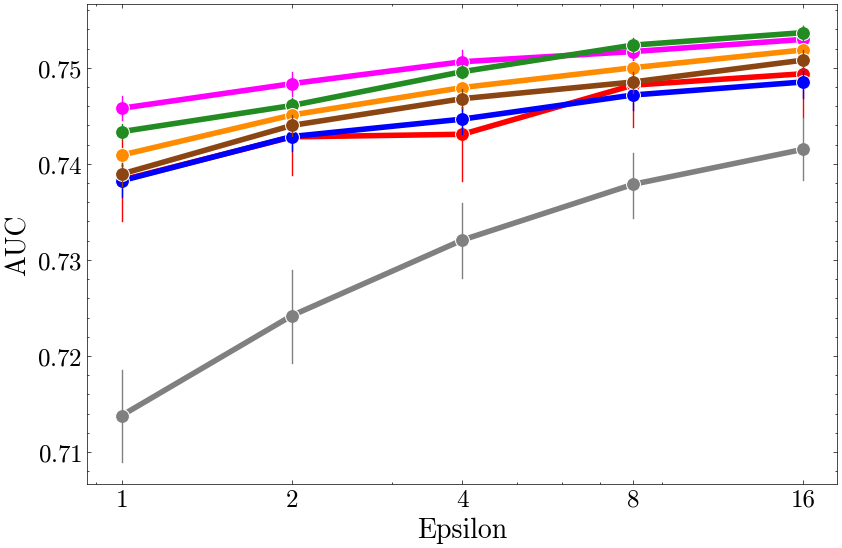

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data

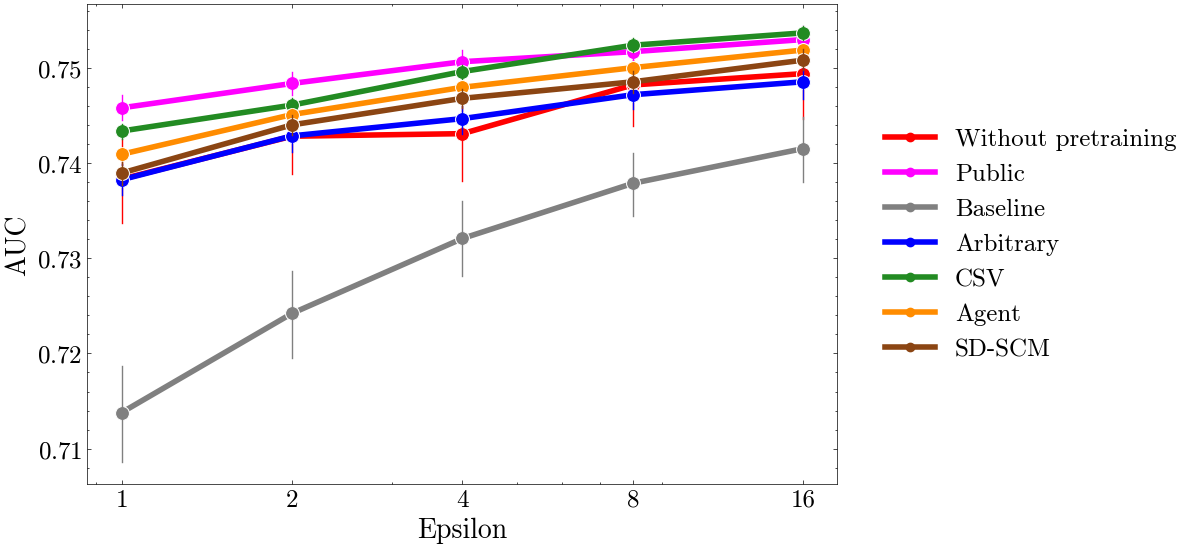

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data (Advantage)

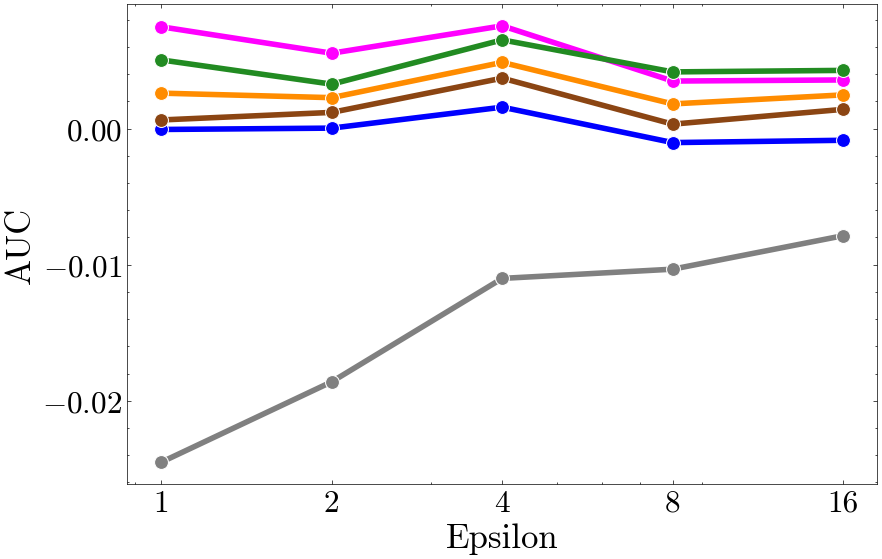

Mean AUC Advantage of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data (Advantage)

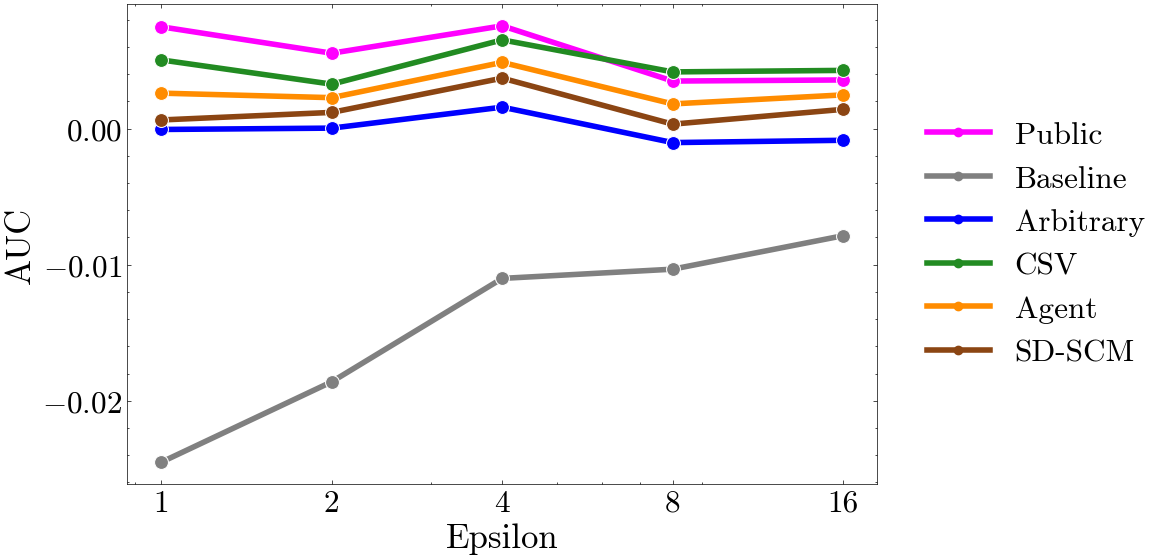

Mean AUC Advantage of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data

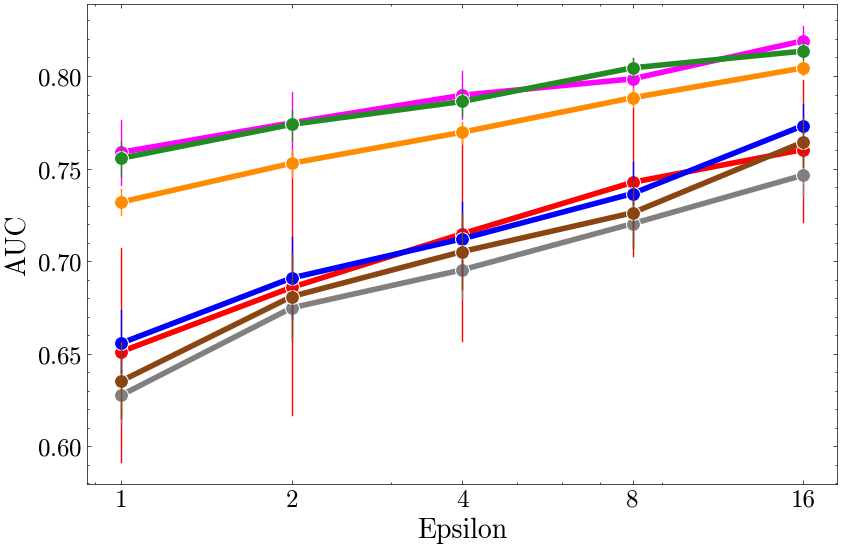

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data

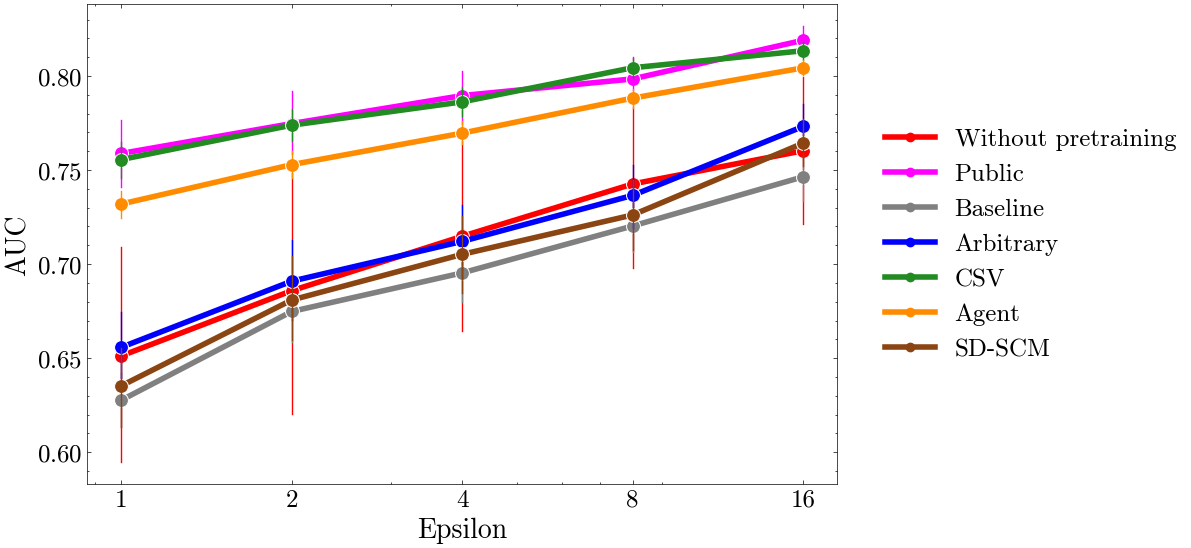

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data (Advantage)

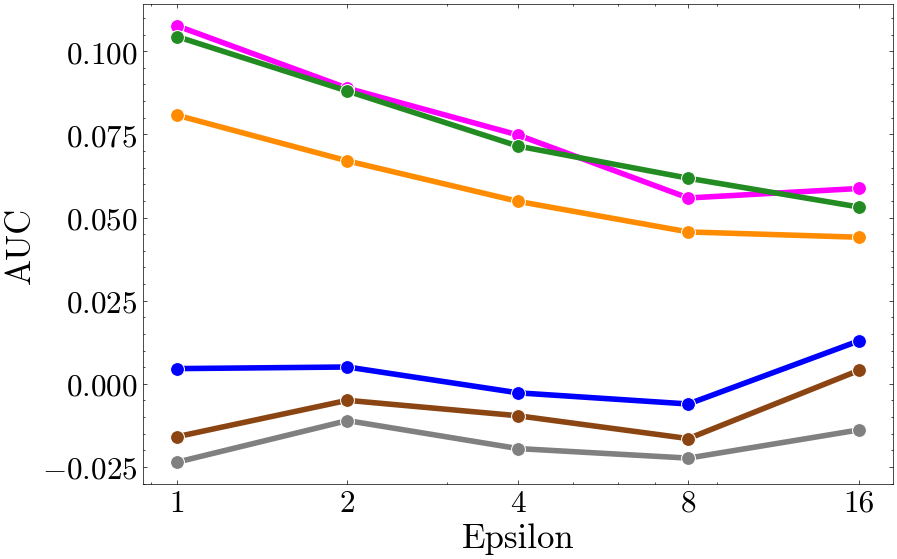

Mean AUC Advantage of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data (Advantage)

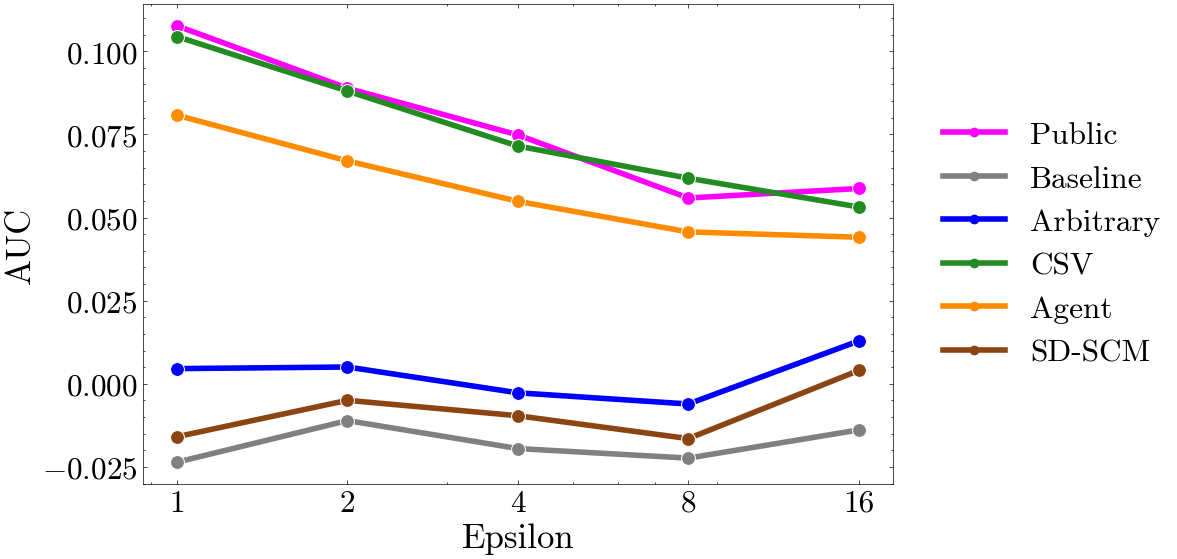

Mean AUC Advantage of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data

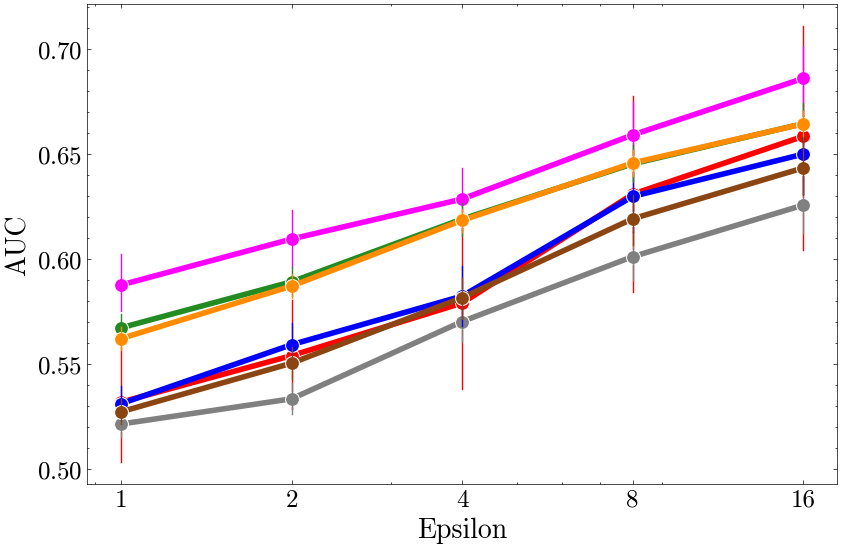

Mean AUC of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data

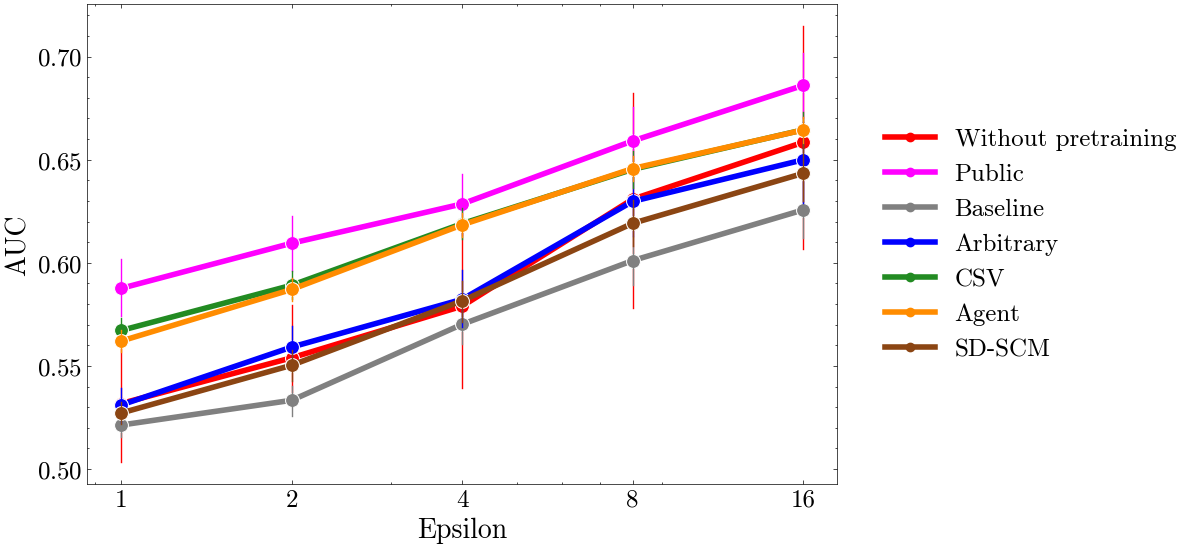

Mean AUC of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data (Advantage)

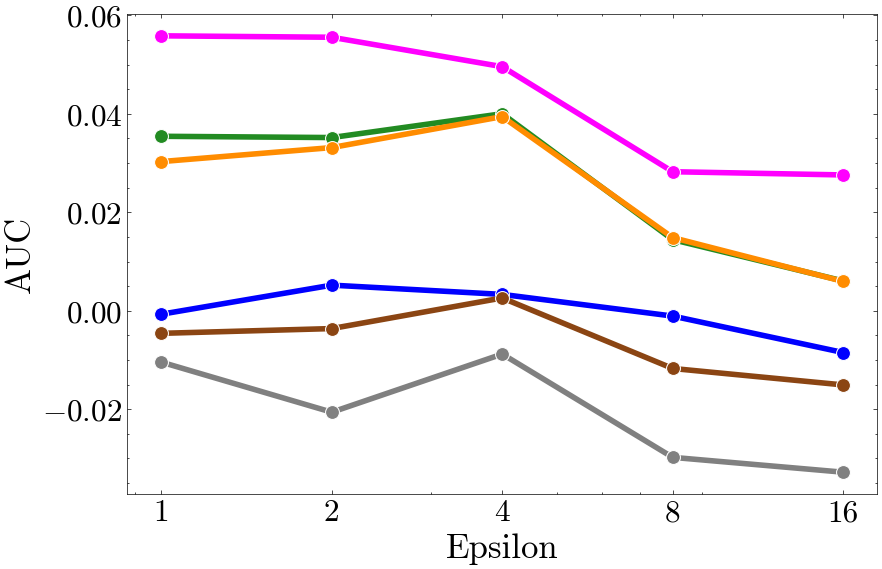

Mean AUC Advantage of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data (Advantage)

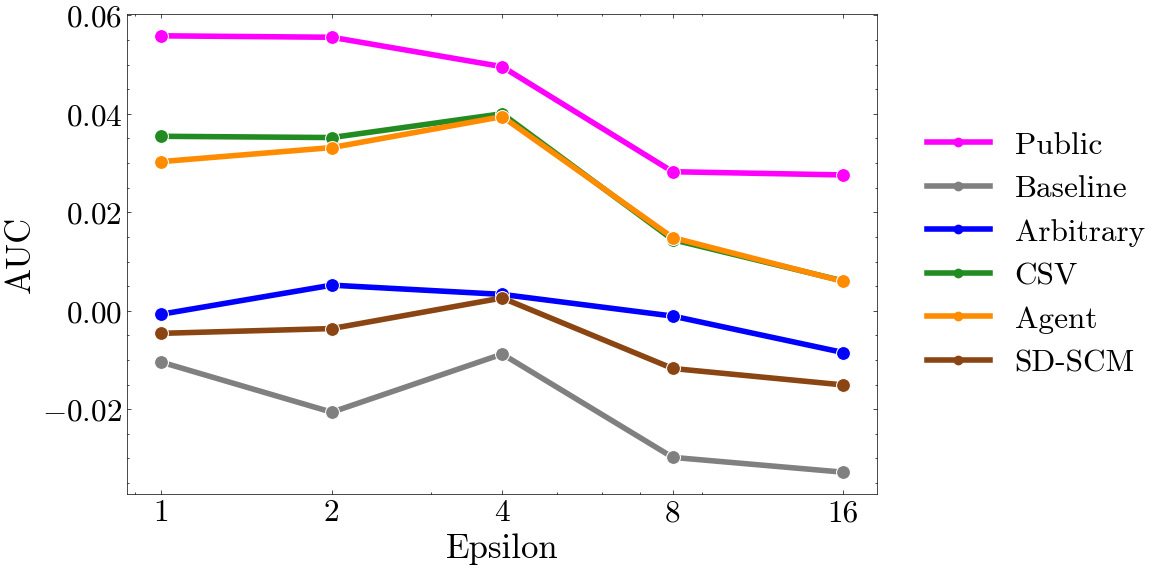

Mean AUC Advantage of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data

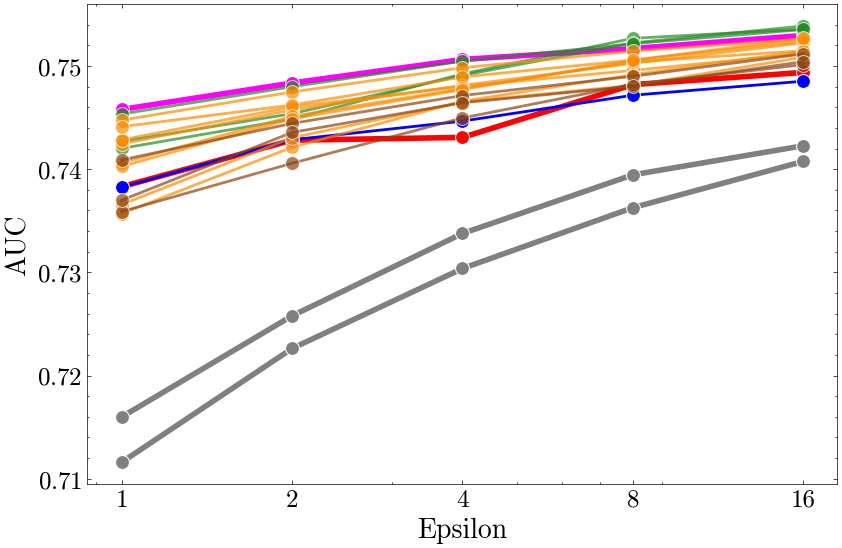

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data

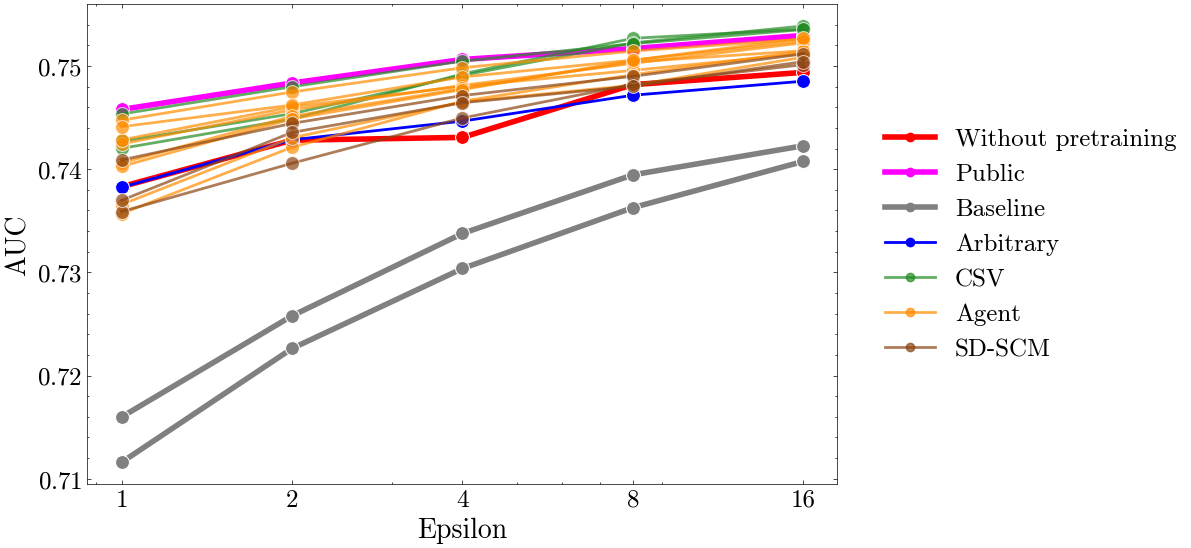

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data

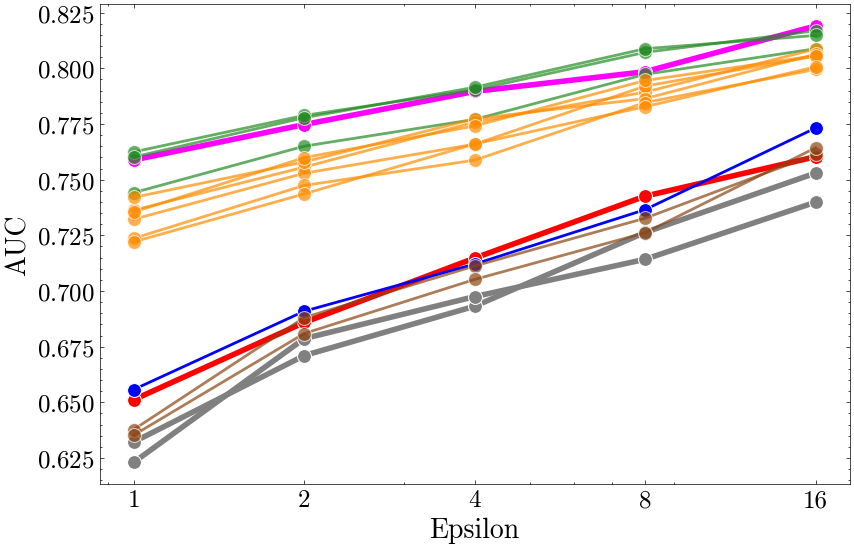

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### EDAD Data

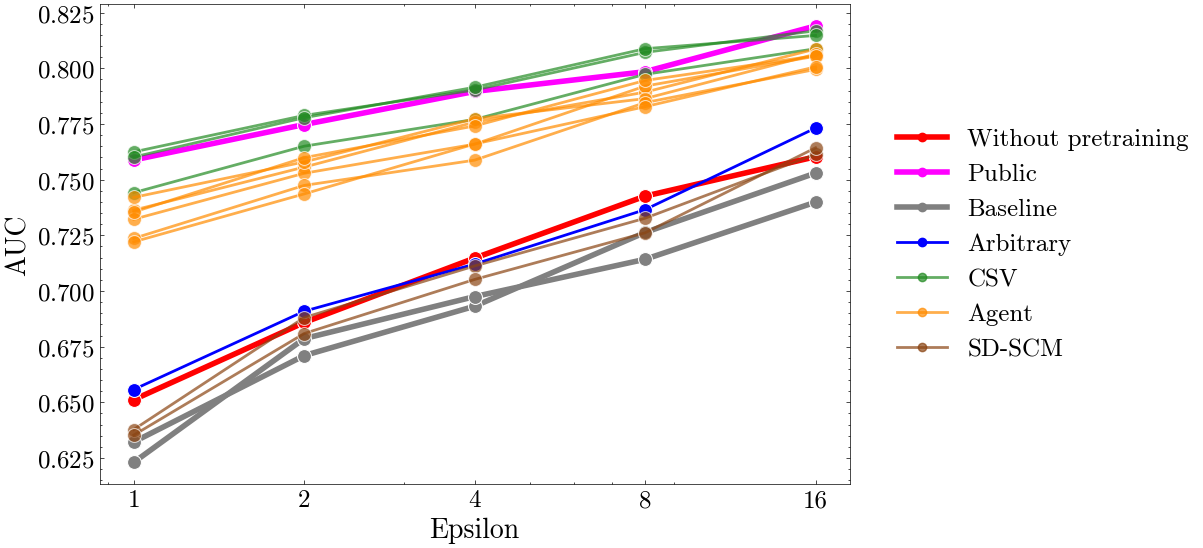

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data

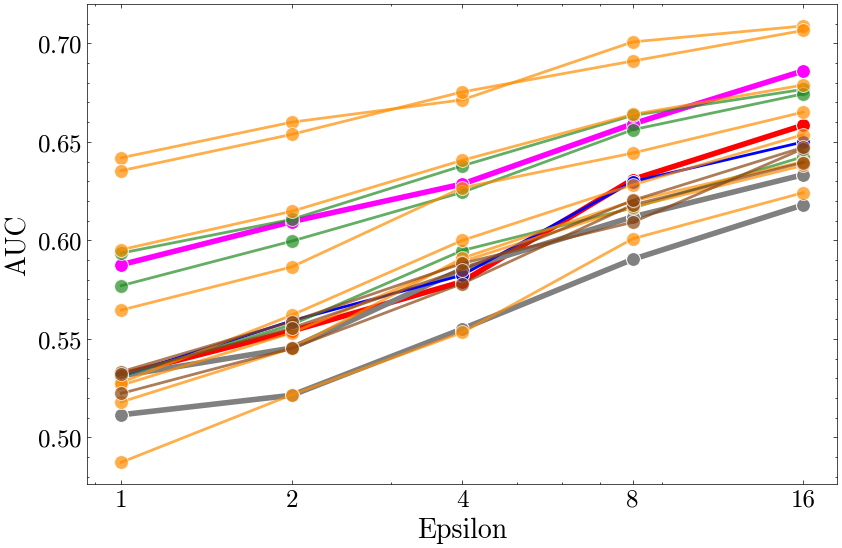

Mean AUC of the DP model on WE data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### WE Data

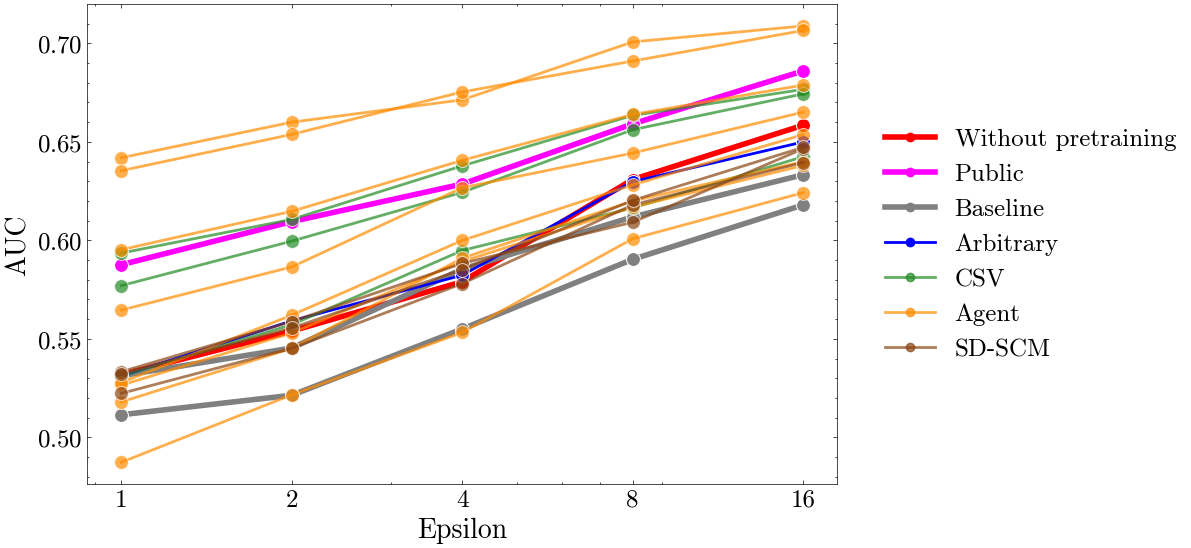

Mean AUC of the DP model on WE data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space, with 10 runs per hyperparameter configuration.

### ACS Data (Best)

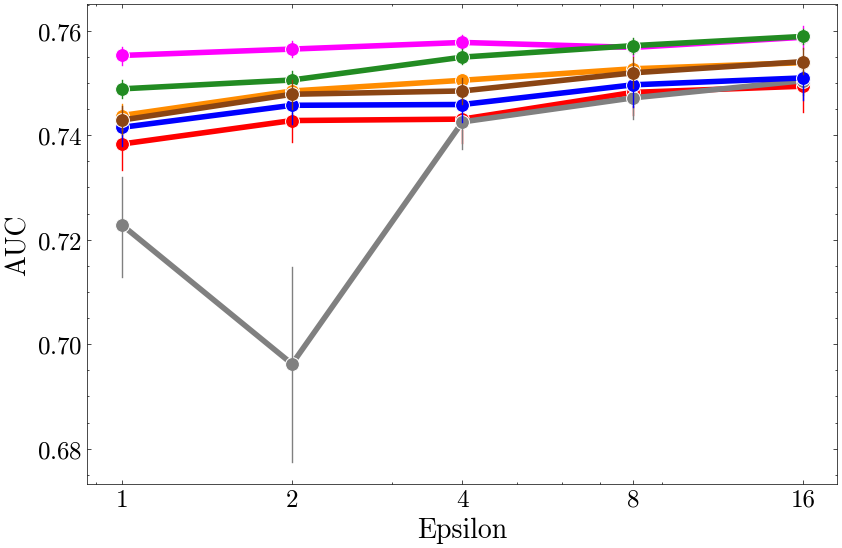

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### ACS Data (Best)

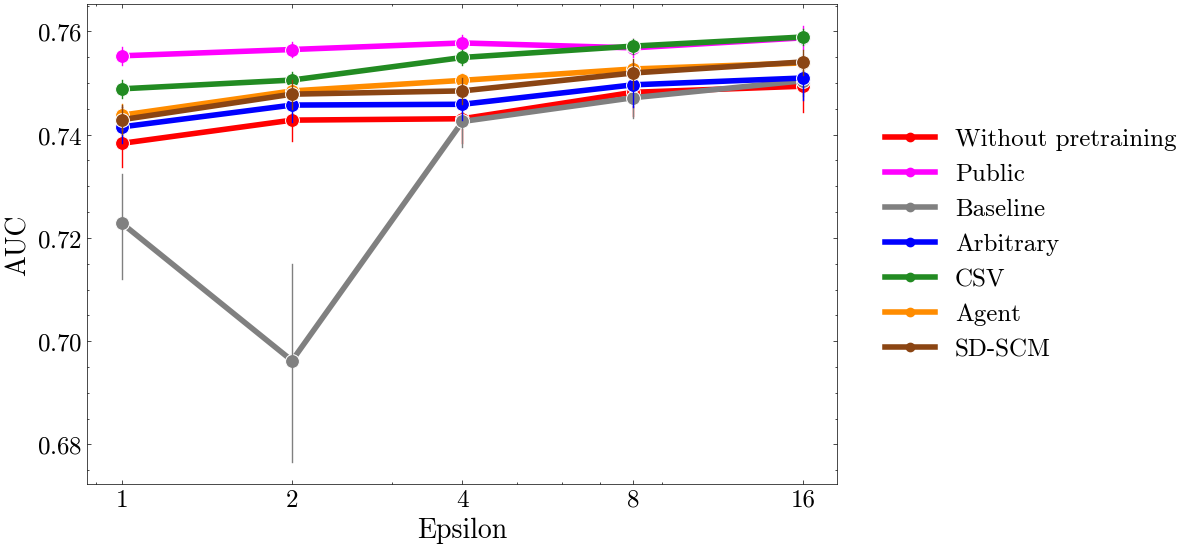

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### ACS Data (Advantage) (Best)

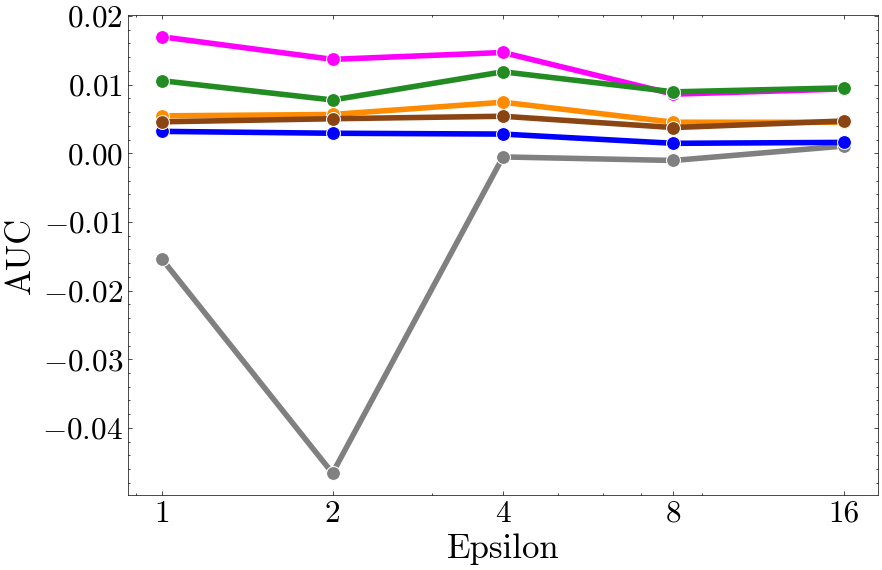

Mean AUC Advantage of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### ACS Data (Advantage) (Best)

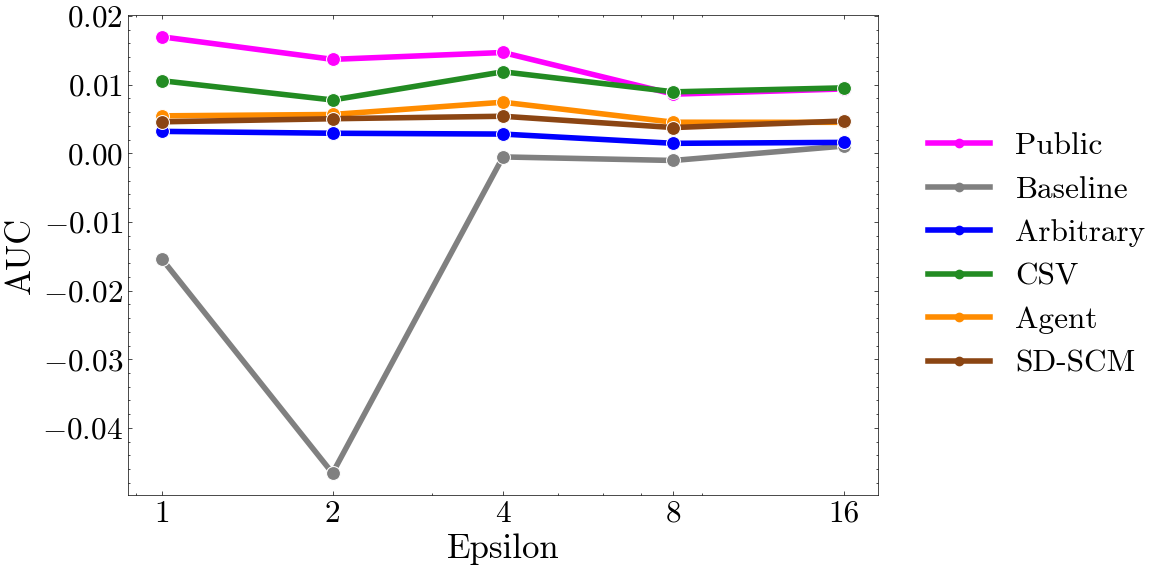

Mean AUC Advantage of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Best)

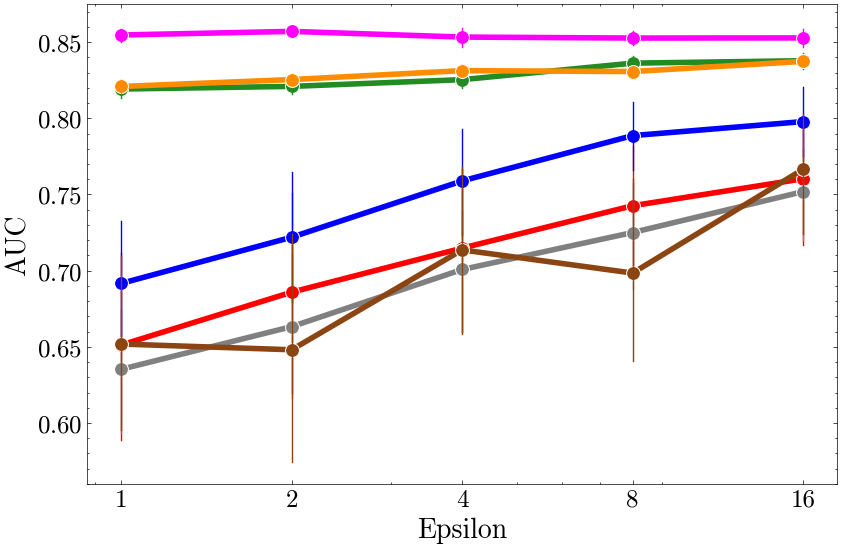

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Best)

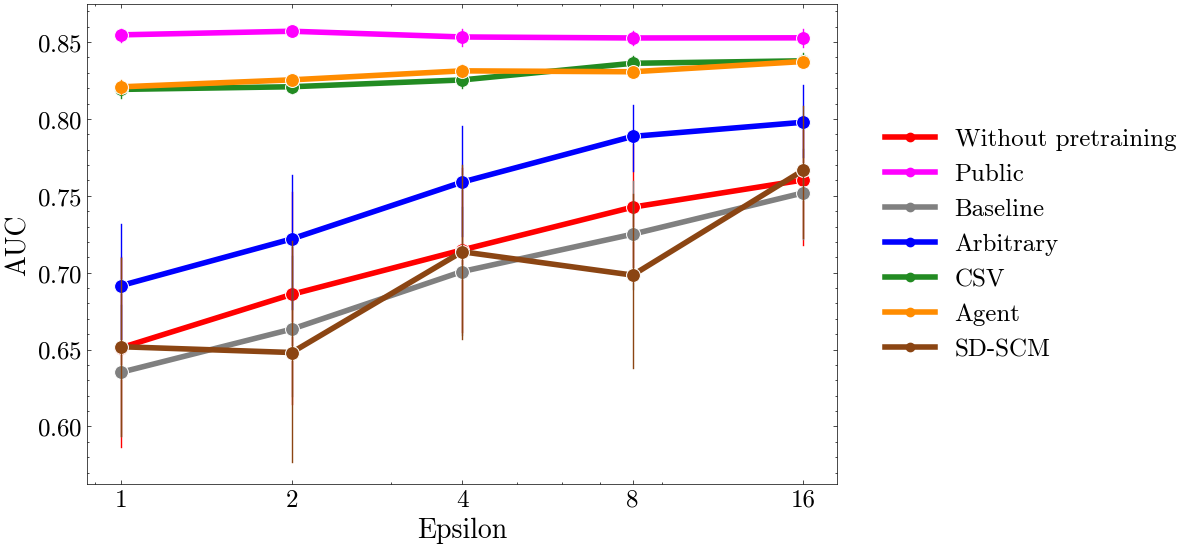

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Advantage) (Best)

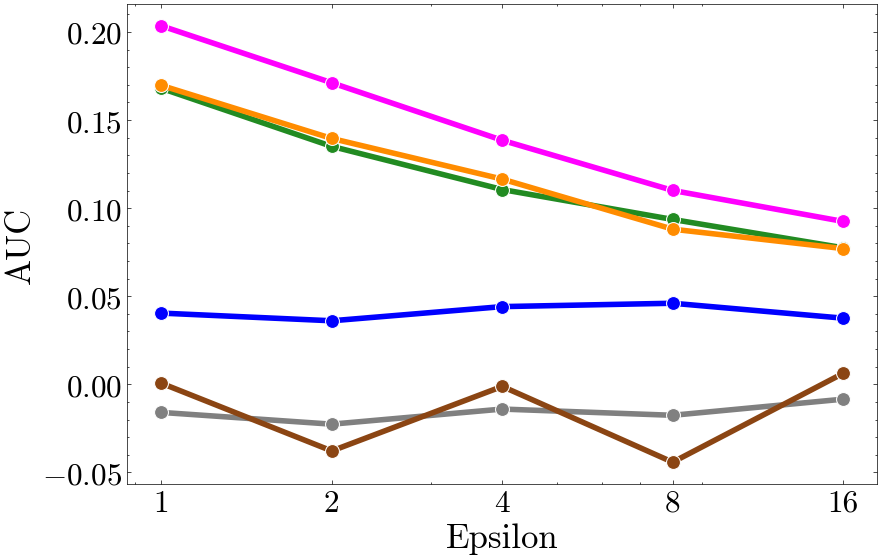

Mean AUC Advantage of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Advantage) (Best)

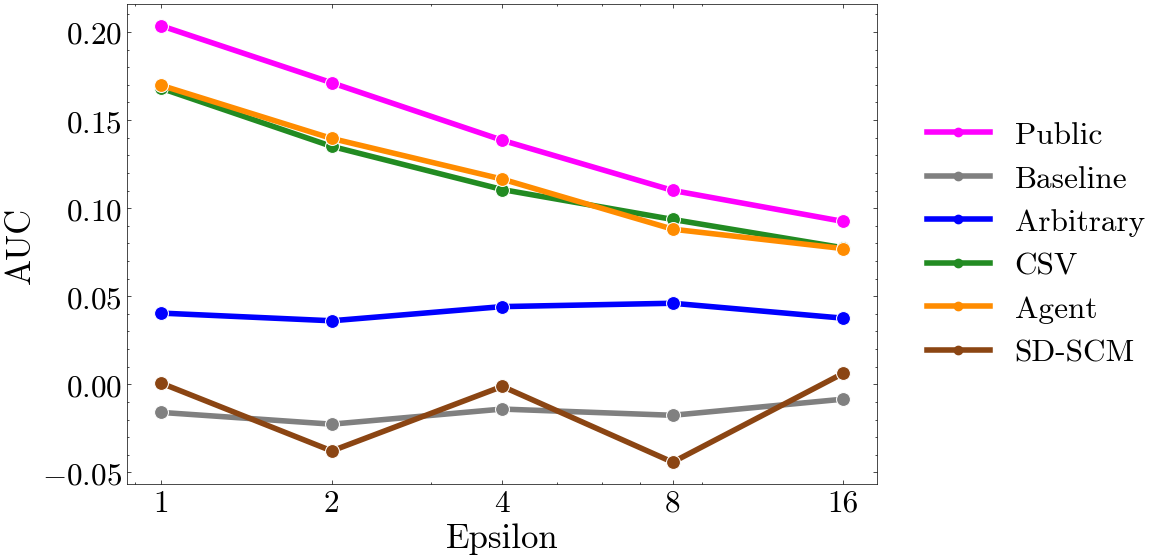

Mean AUC Advantage of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Best)

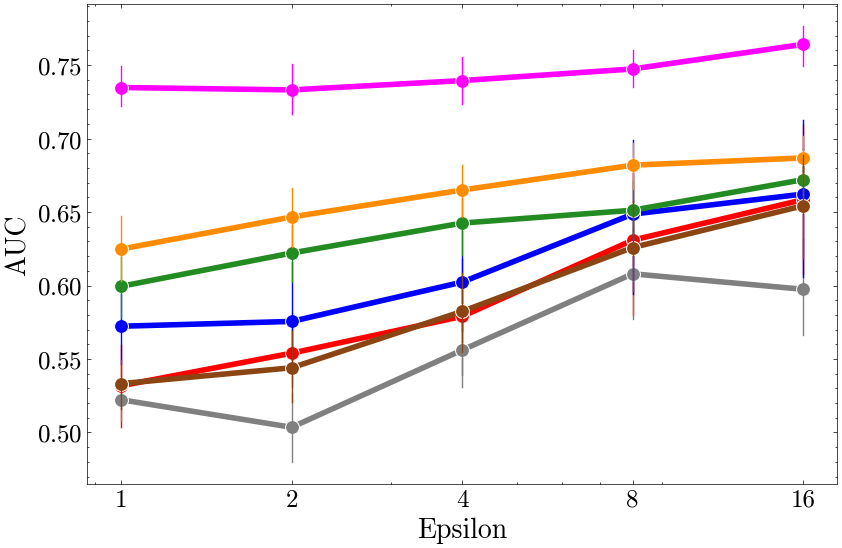

Mean AUC of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Best)

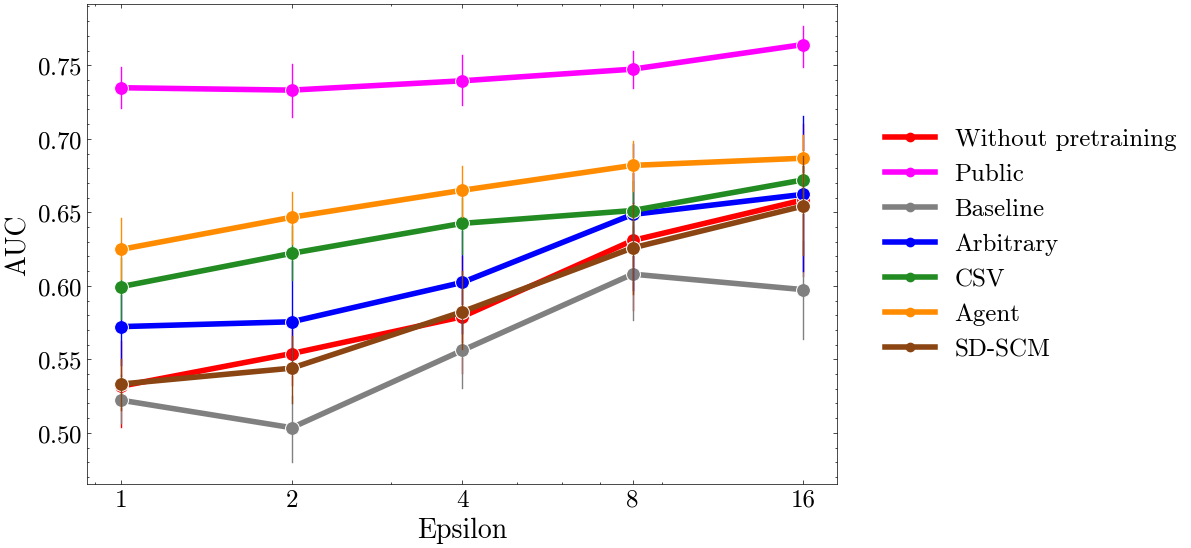

Mean AUC of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Advantage) (Best)

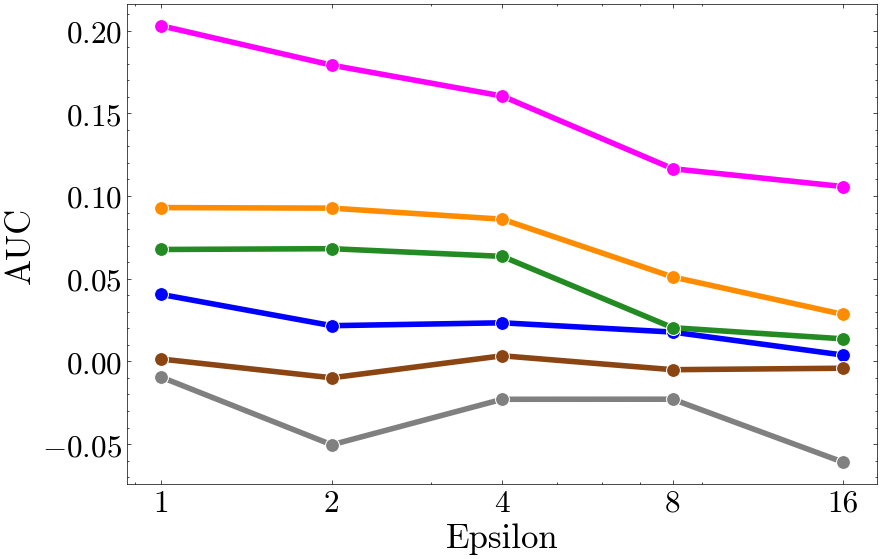

Mean AUC Advantage of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Advantage) (Best)

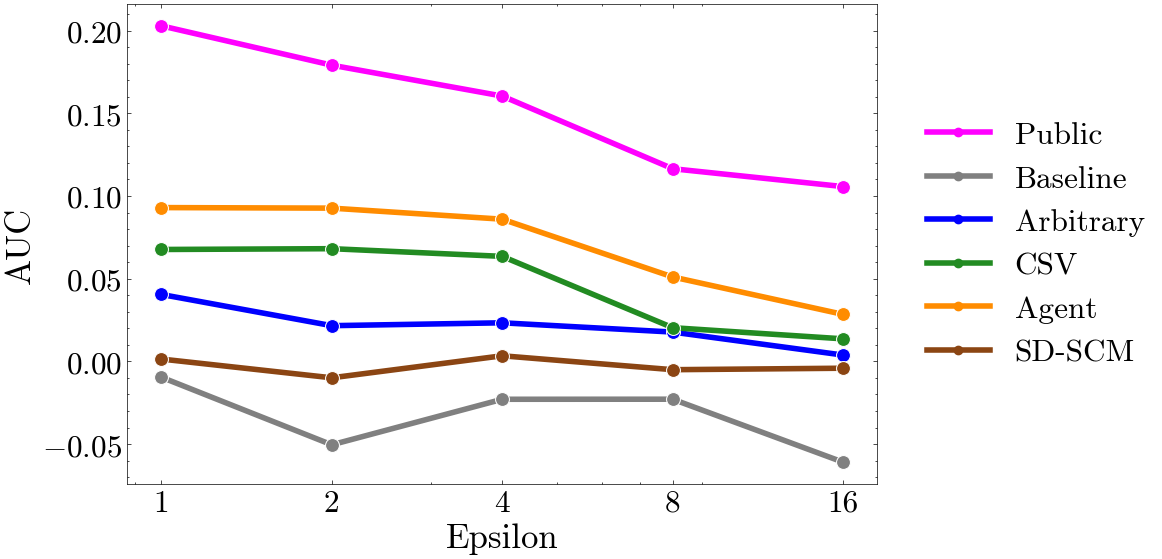

Mean AUC Advantage of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### ACS Data (Best)

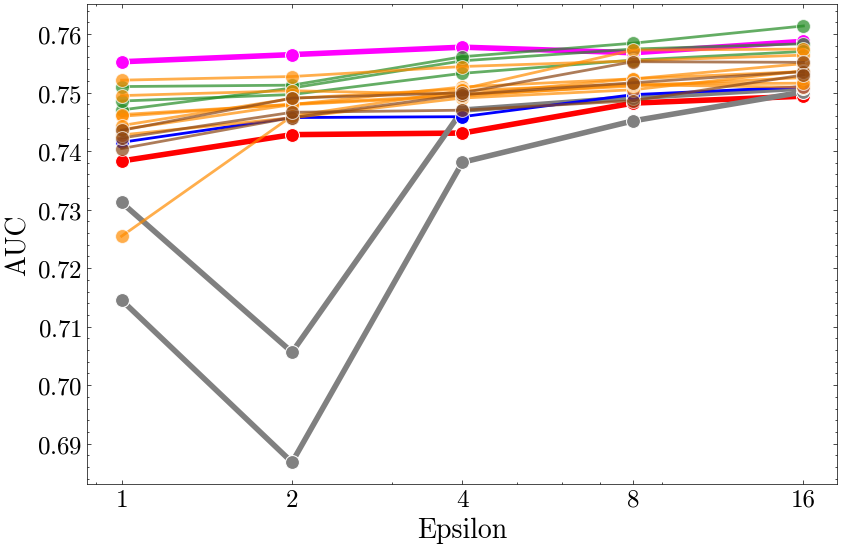

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### ACS Data (Best)

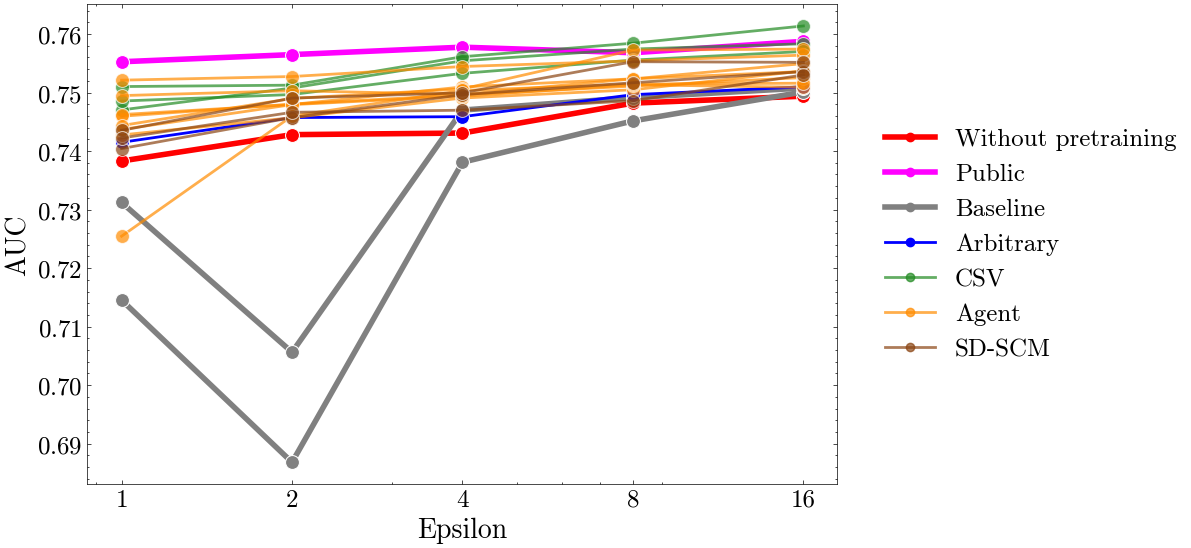

Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Best)

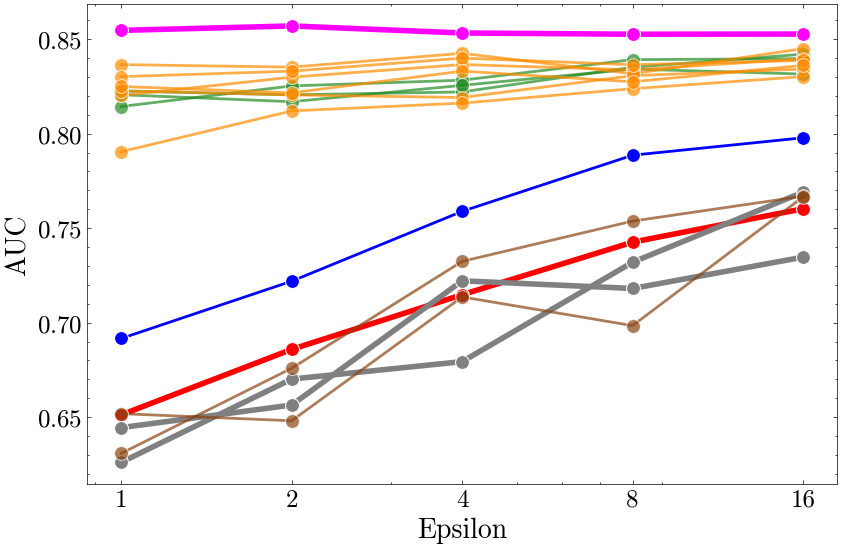

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### EDAD Data (Best)

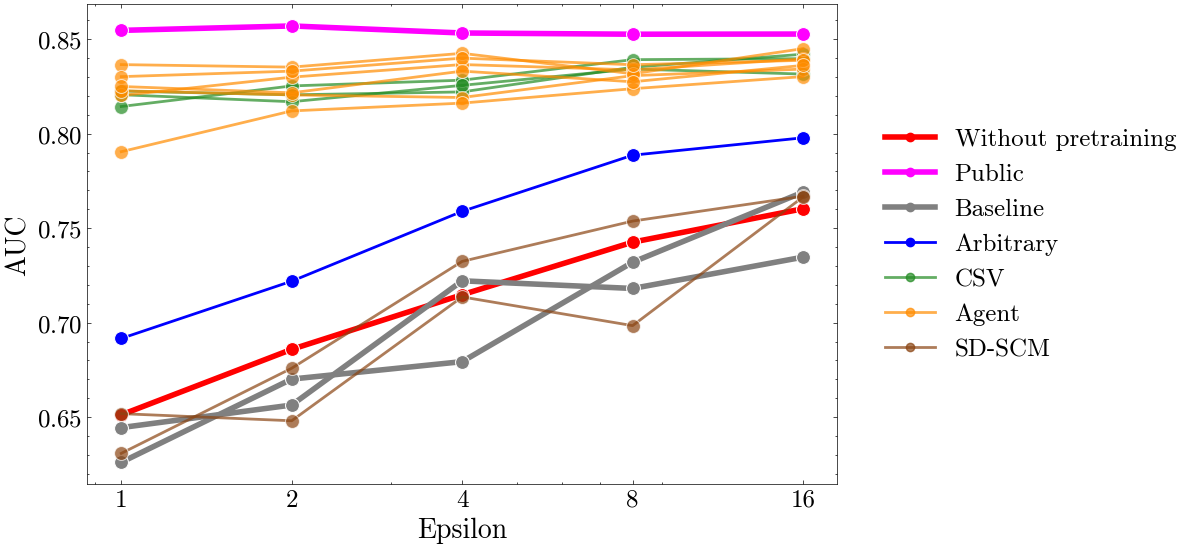

Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Best)

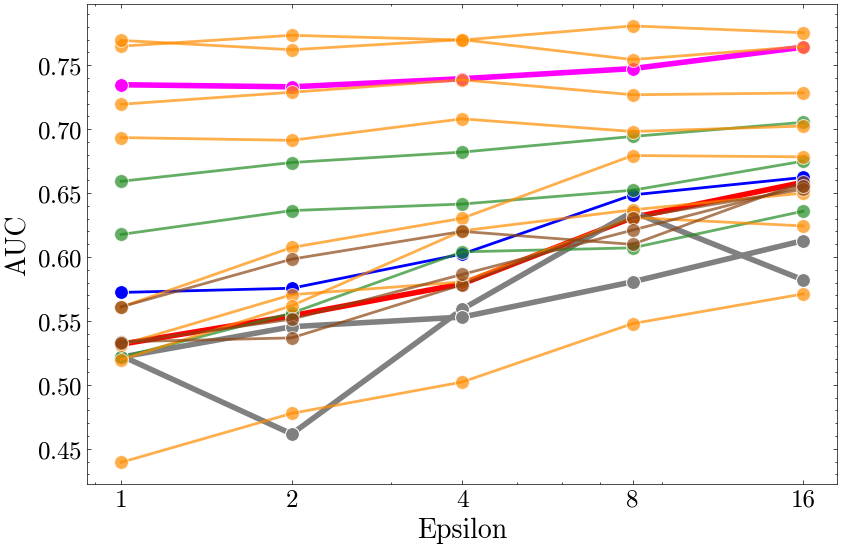

Mean AUC of the DP model on WE data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

### WE Data (Best)

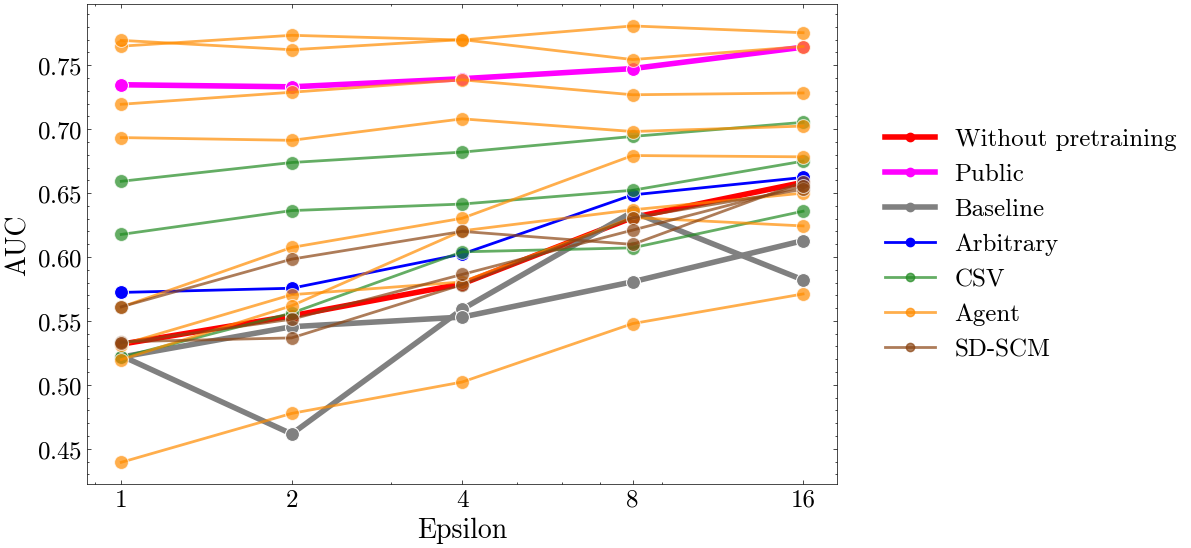

Mean AUC of the DP model on WE data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.

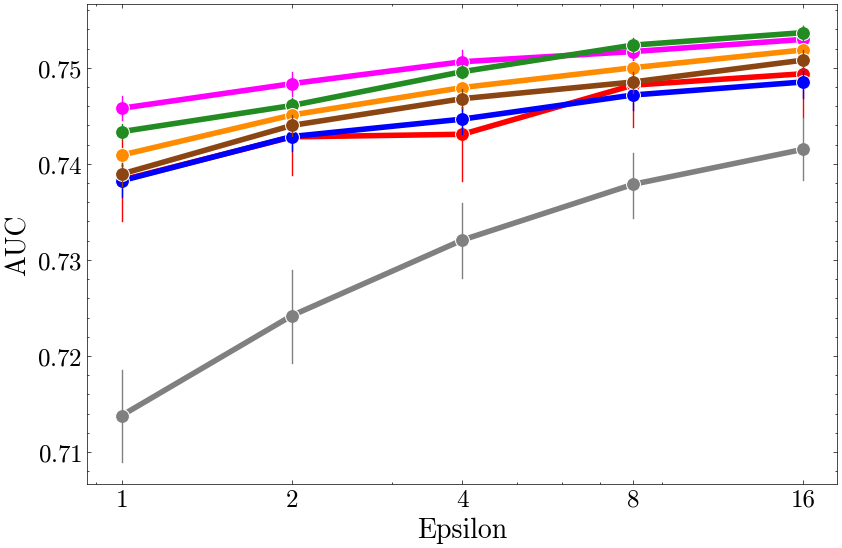

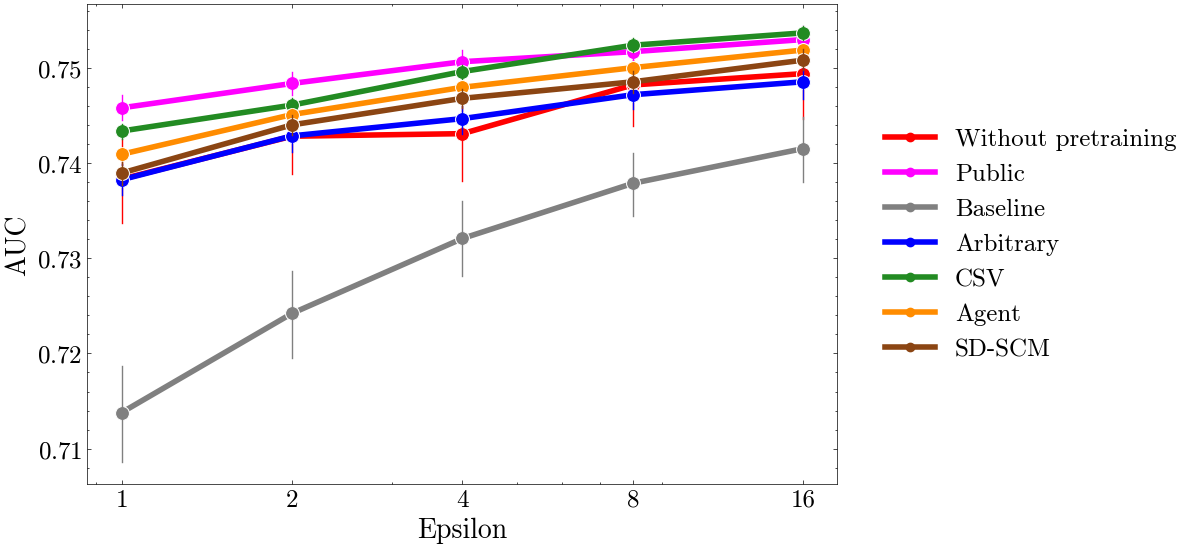

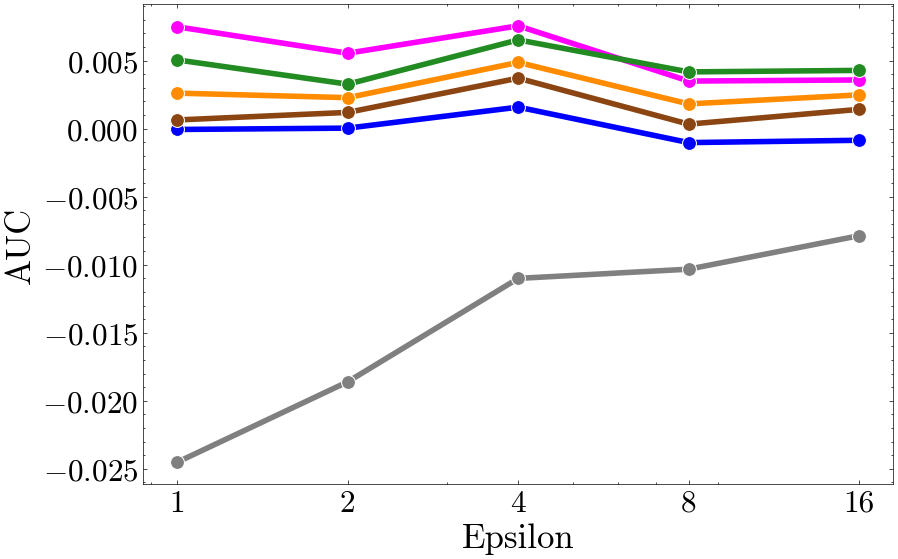

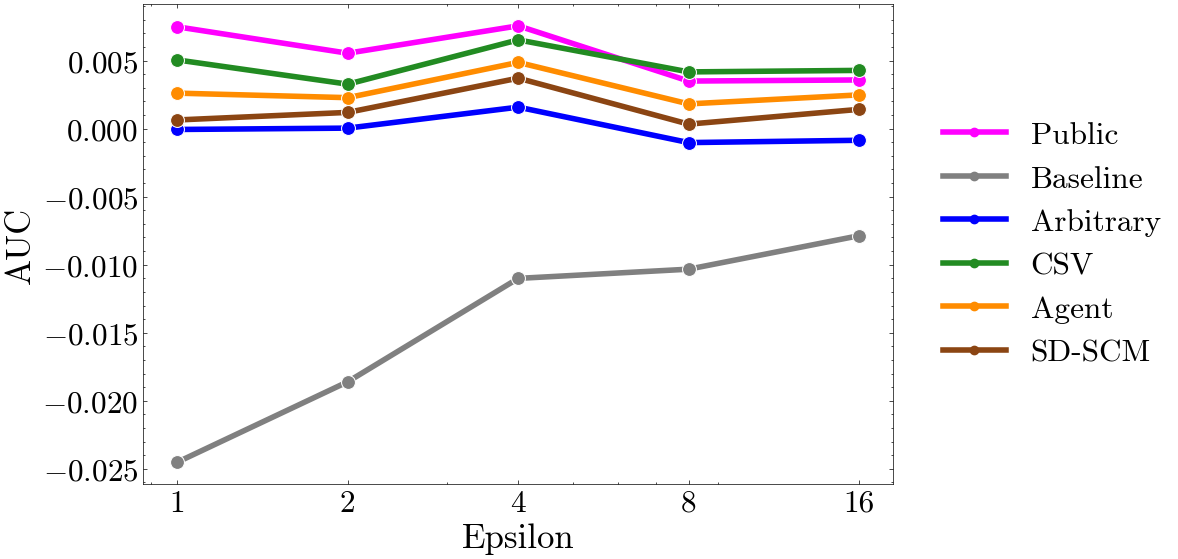

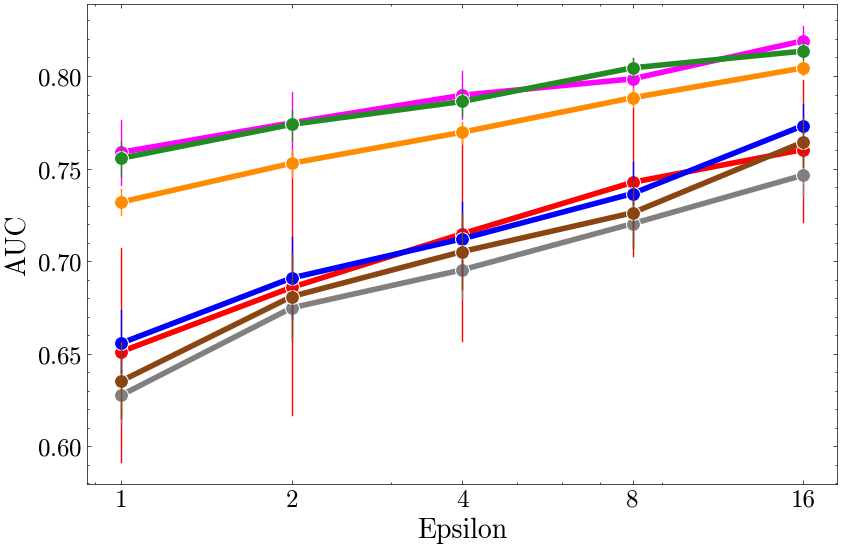

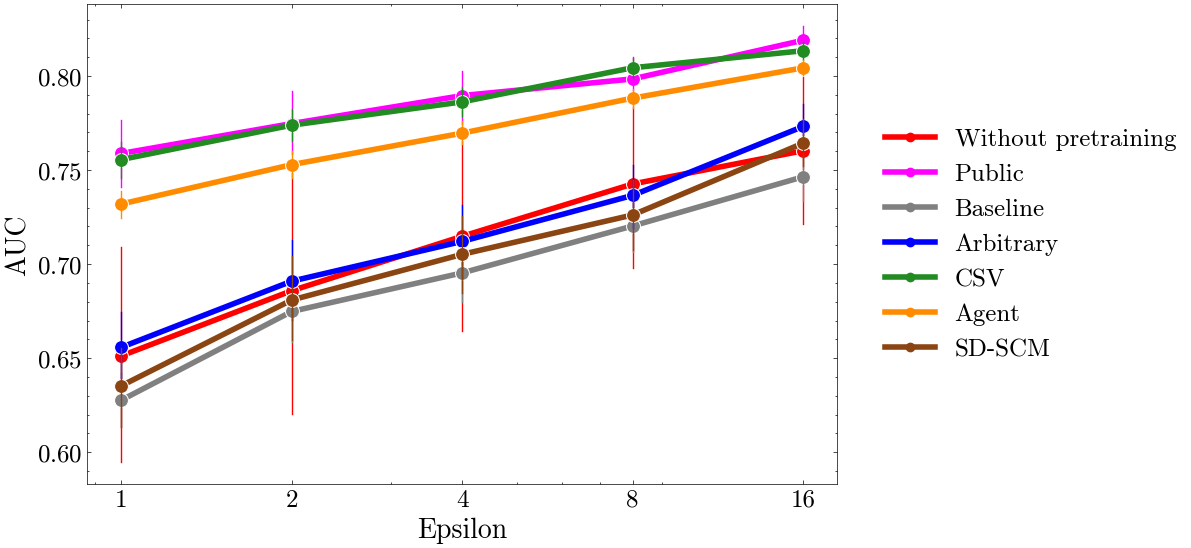

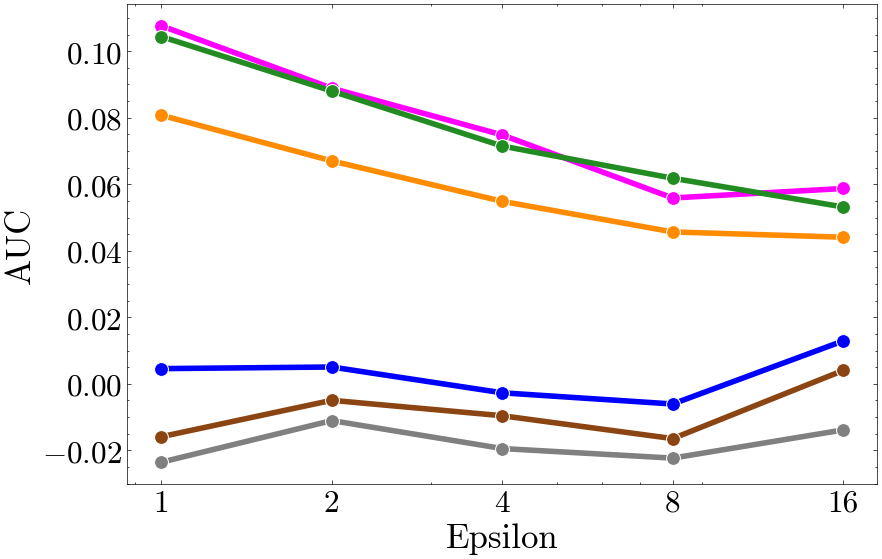

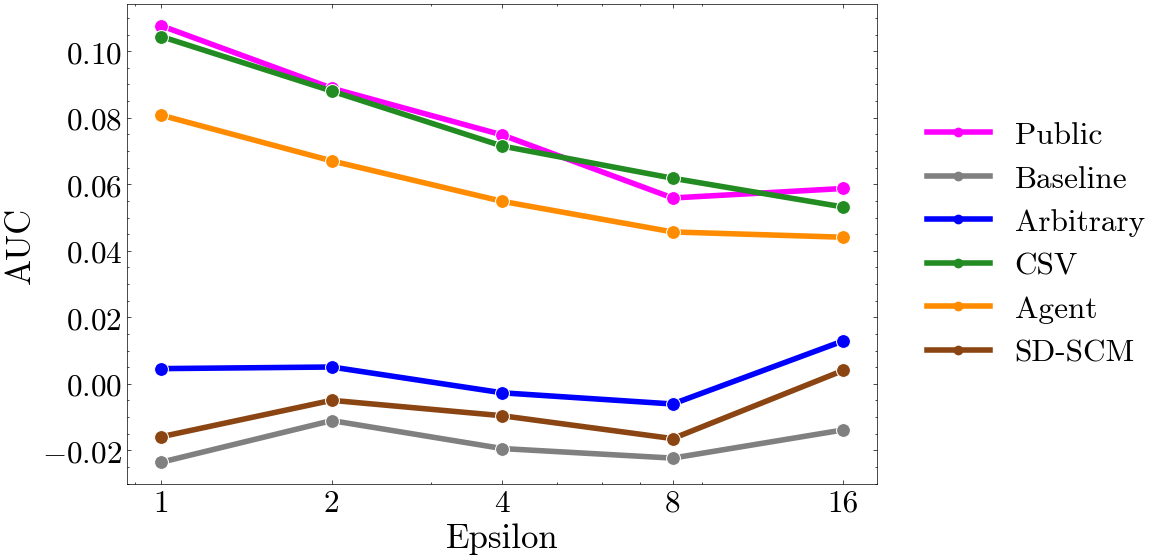

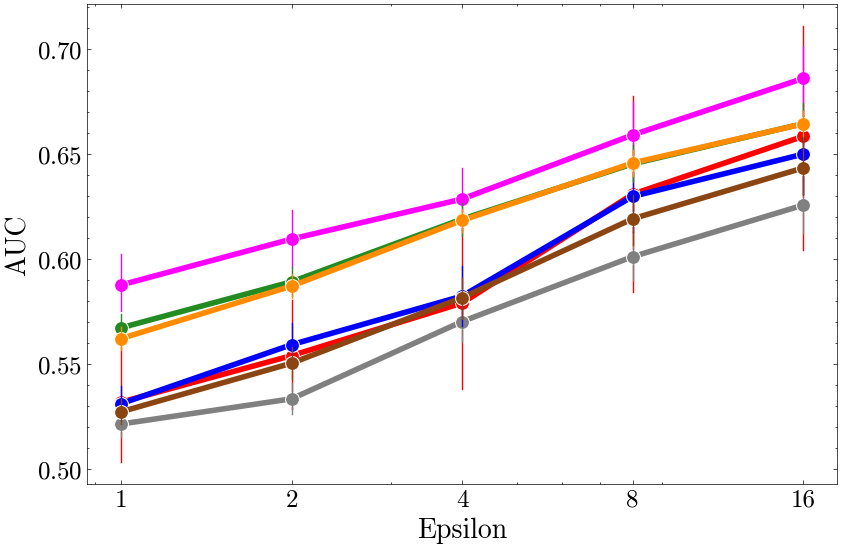

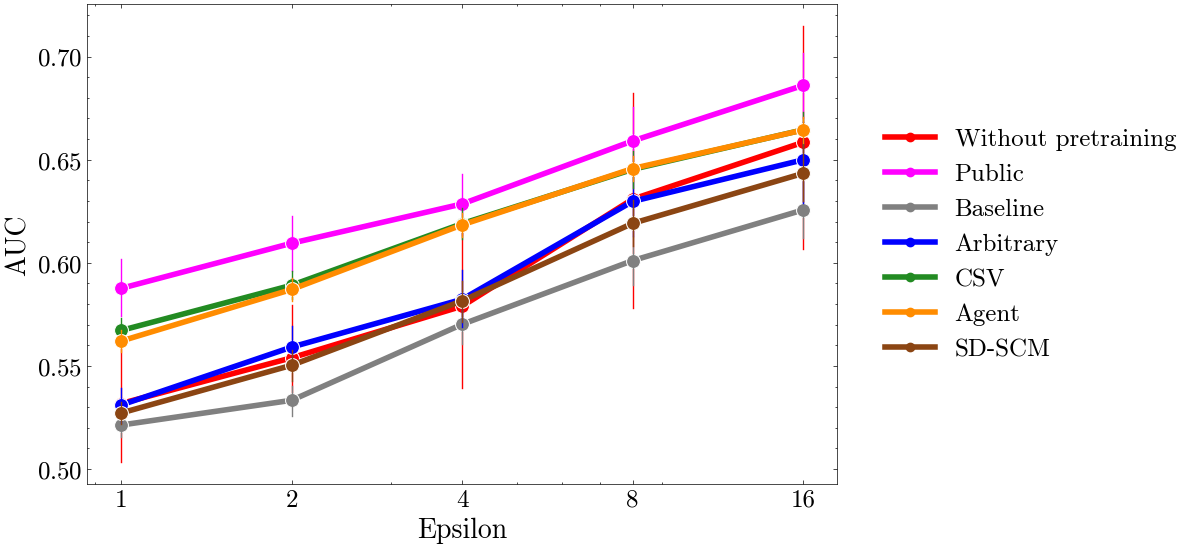

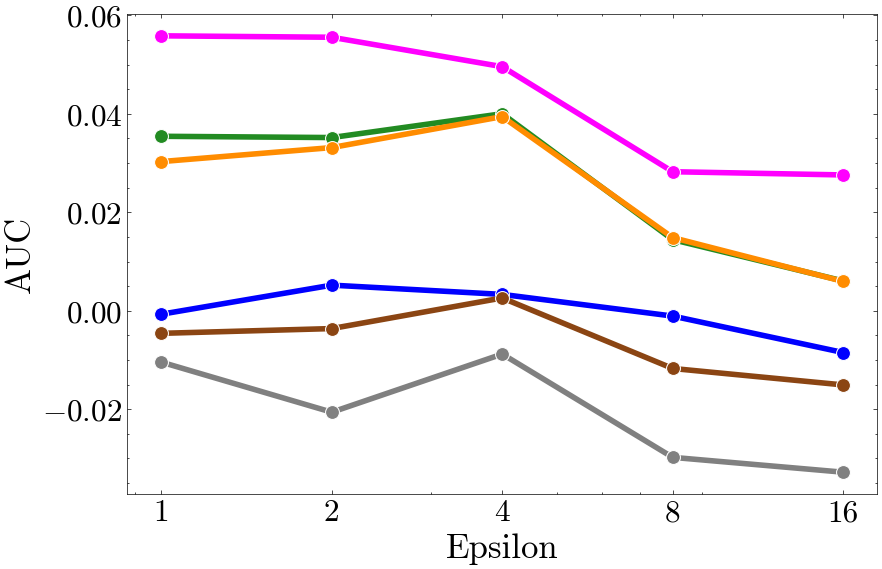

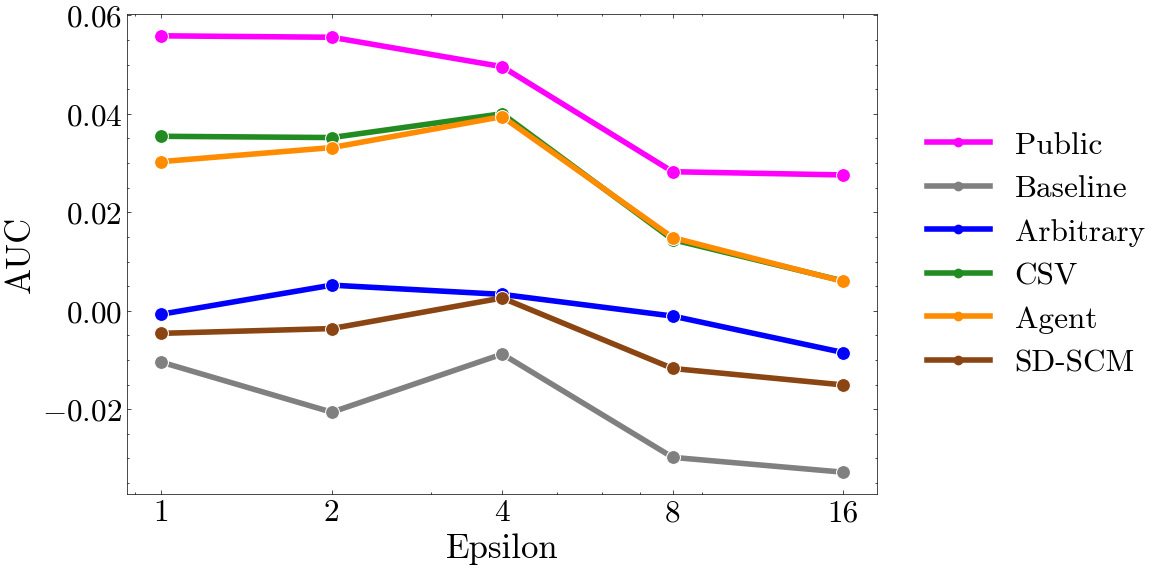

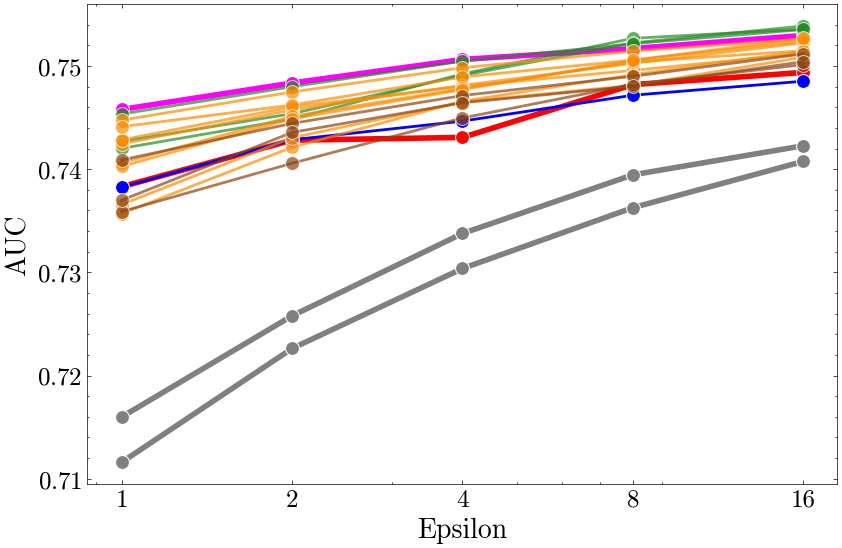

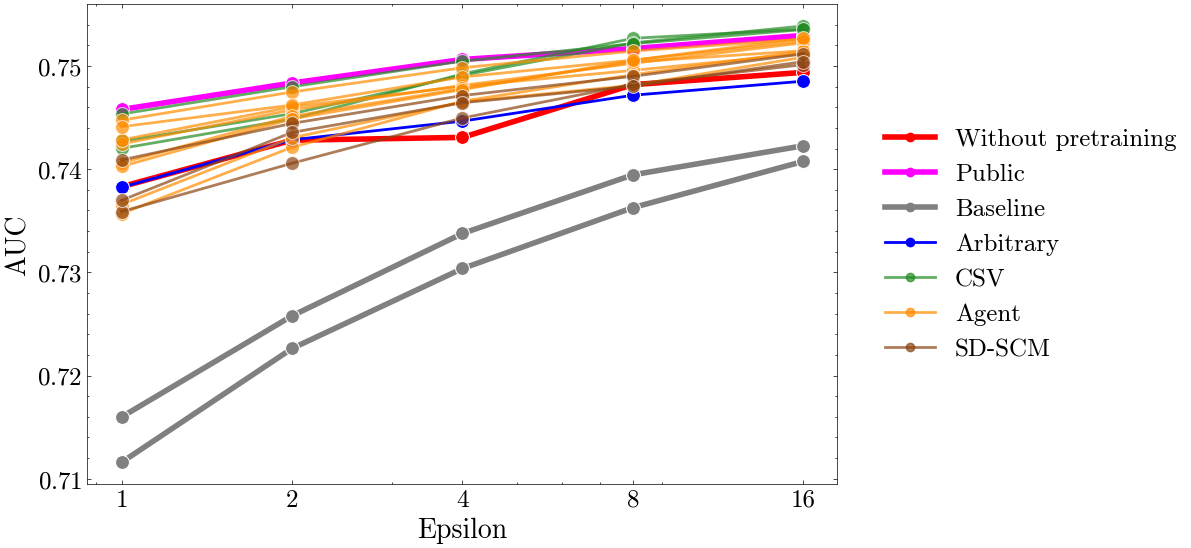

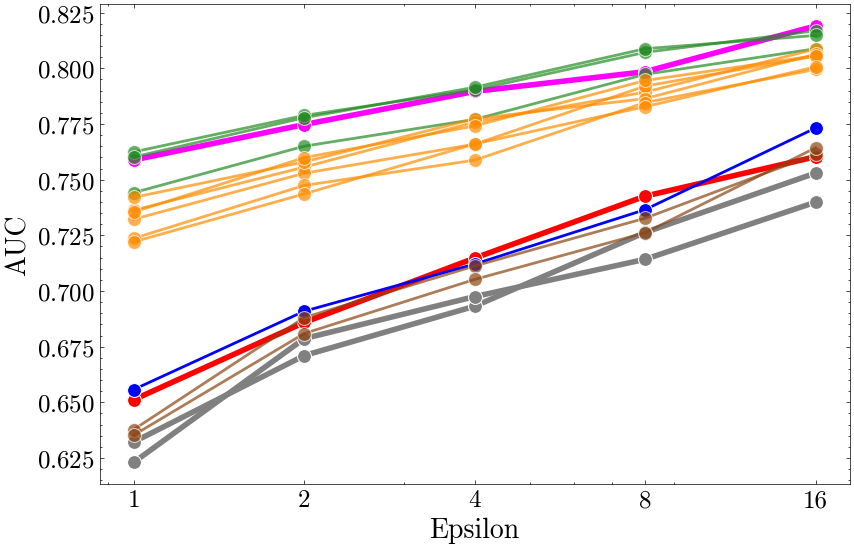

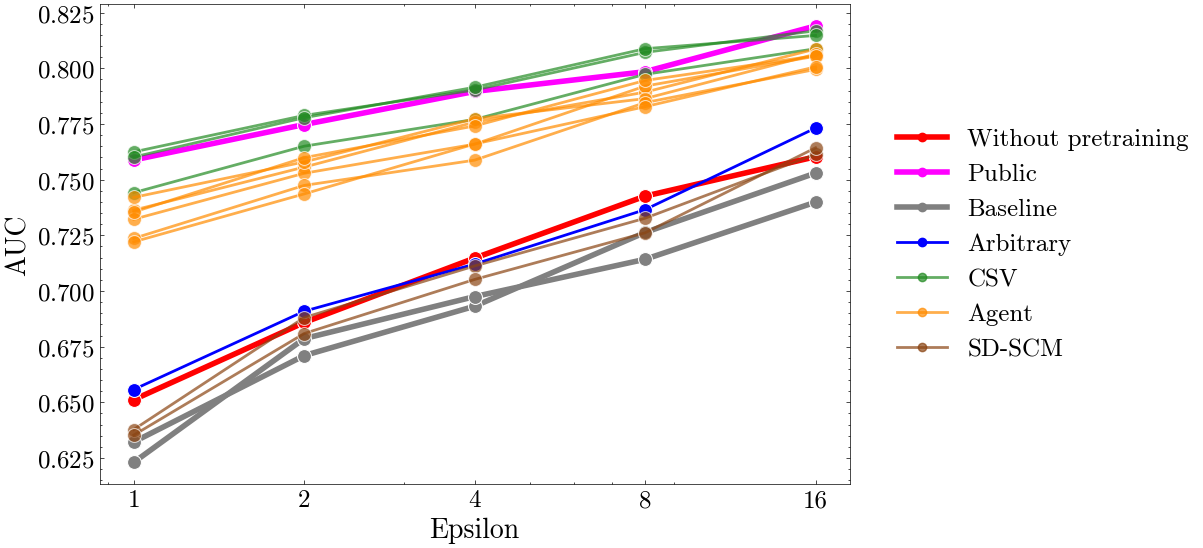

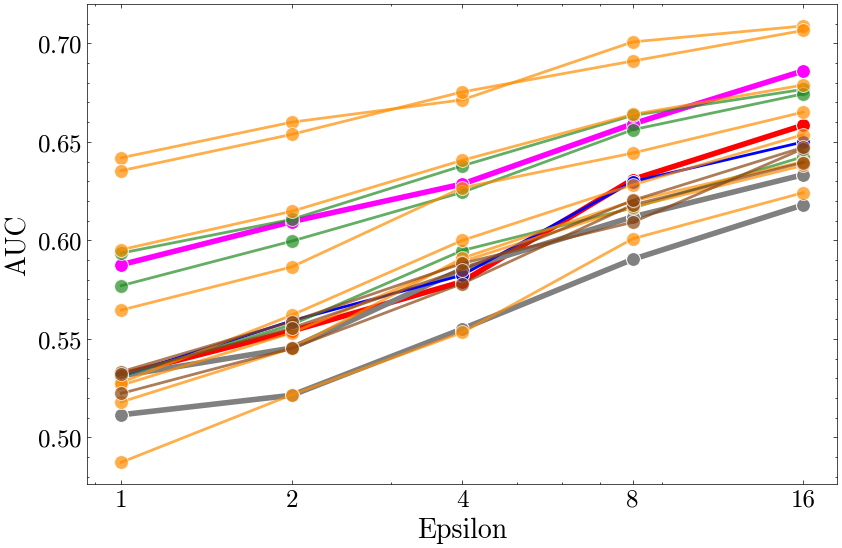

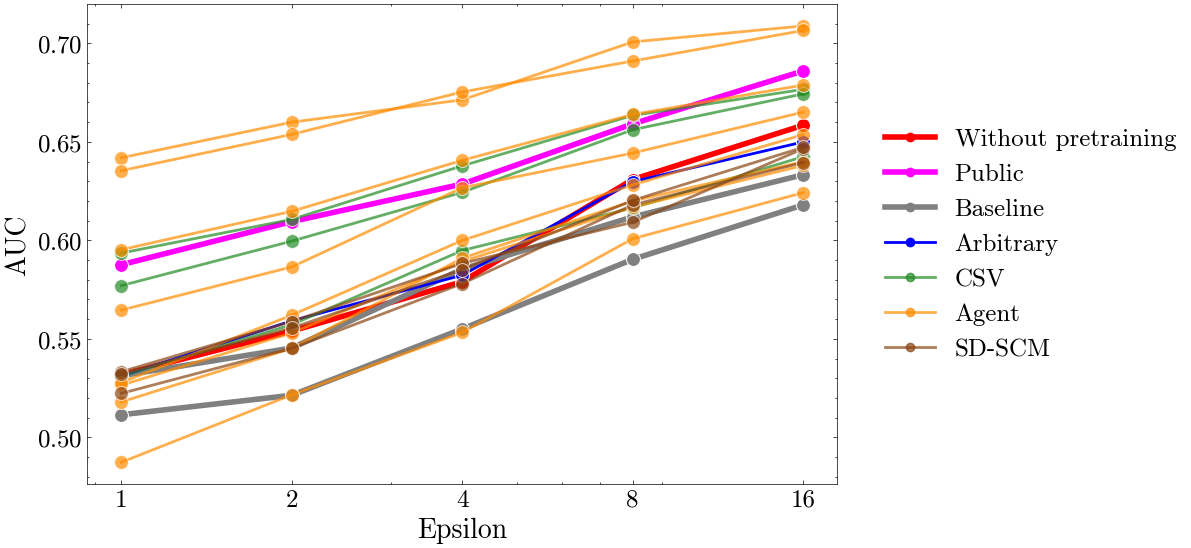

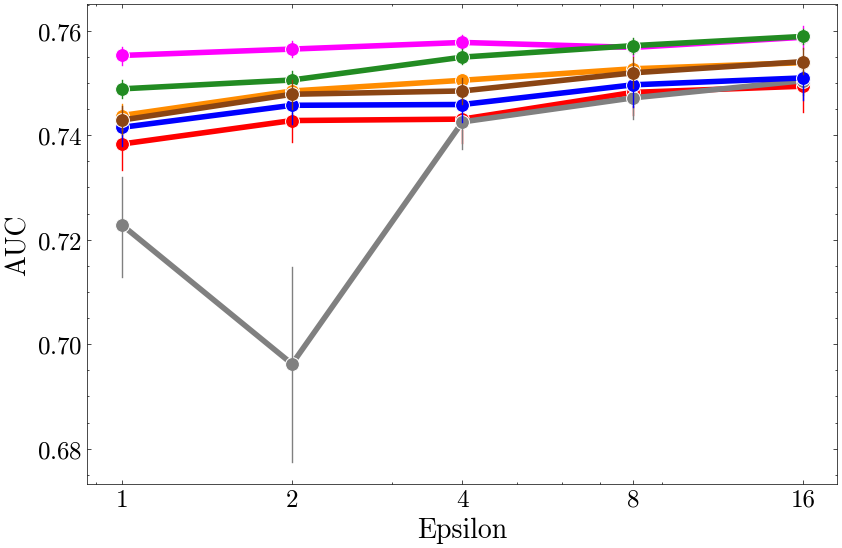

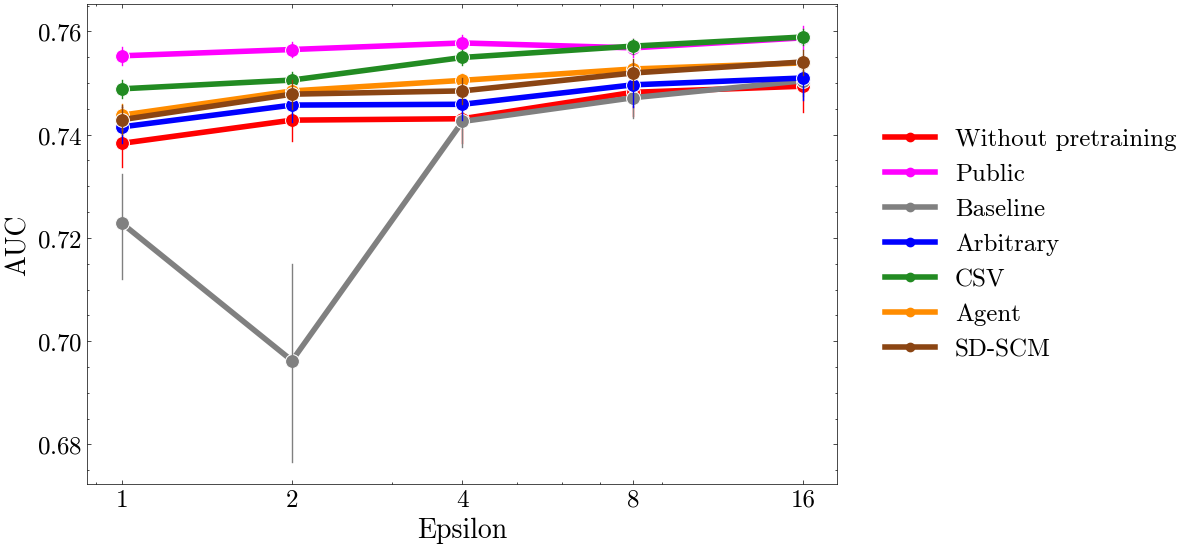

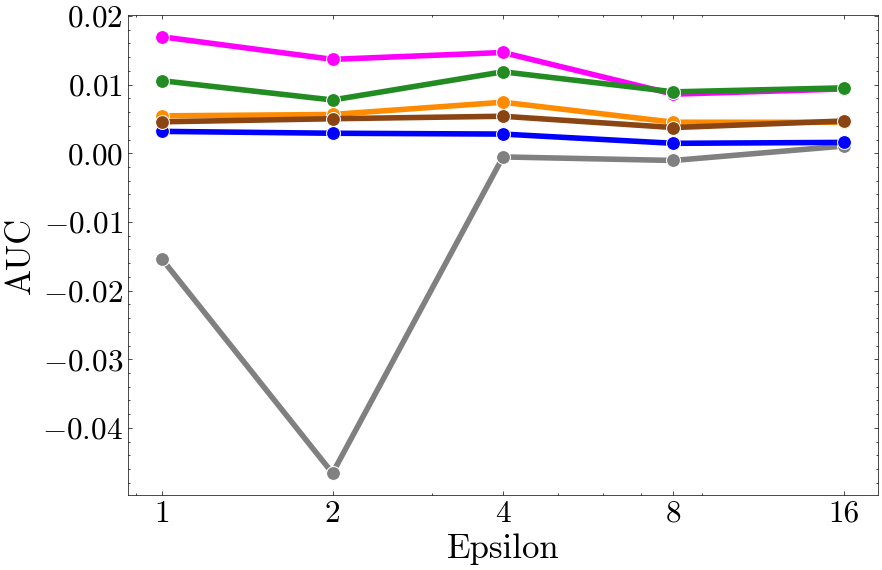

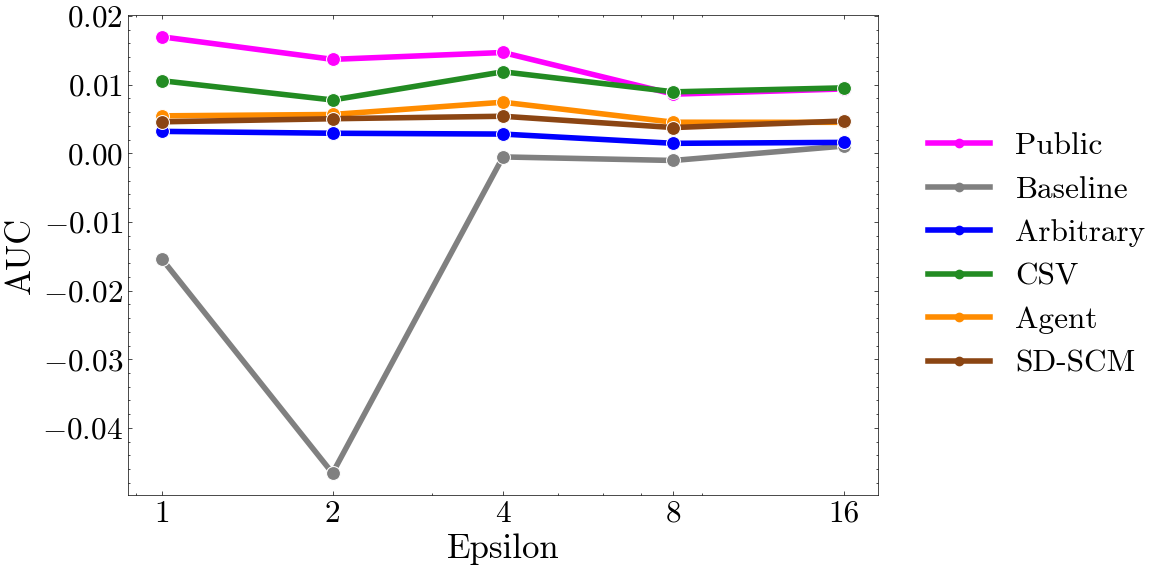

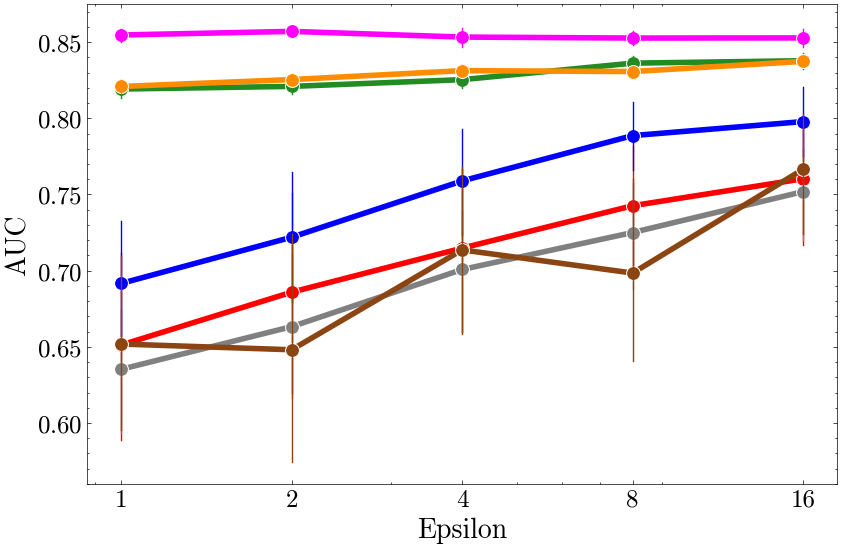

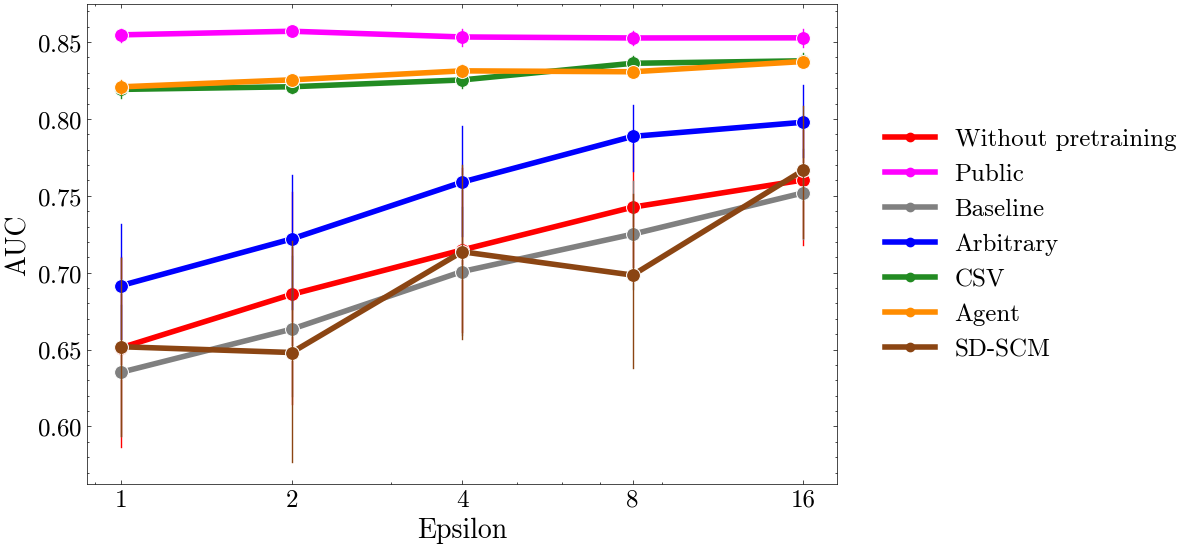

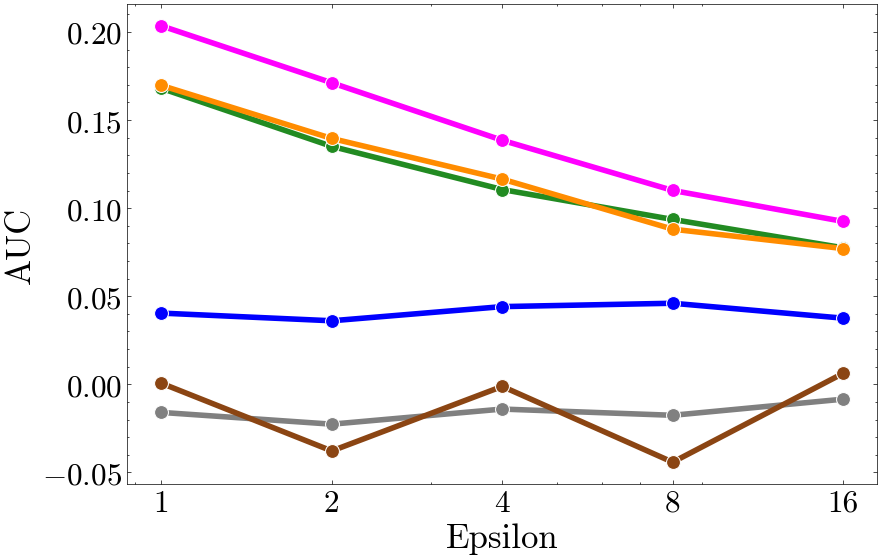

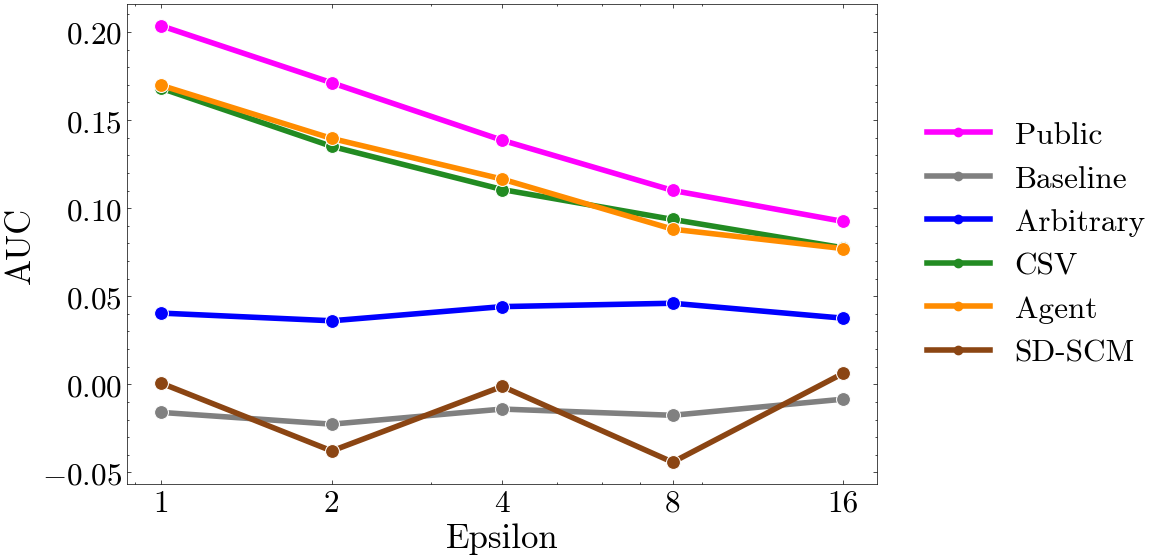

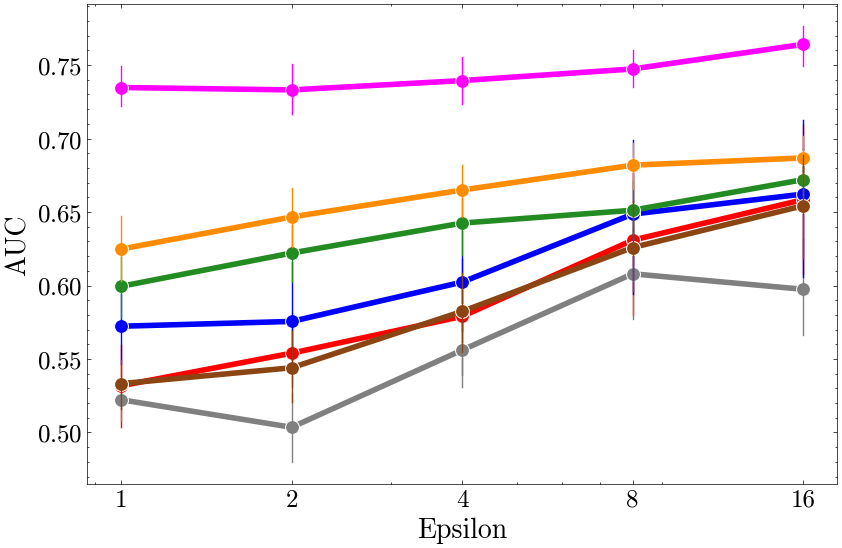

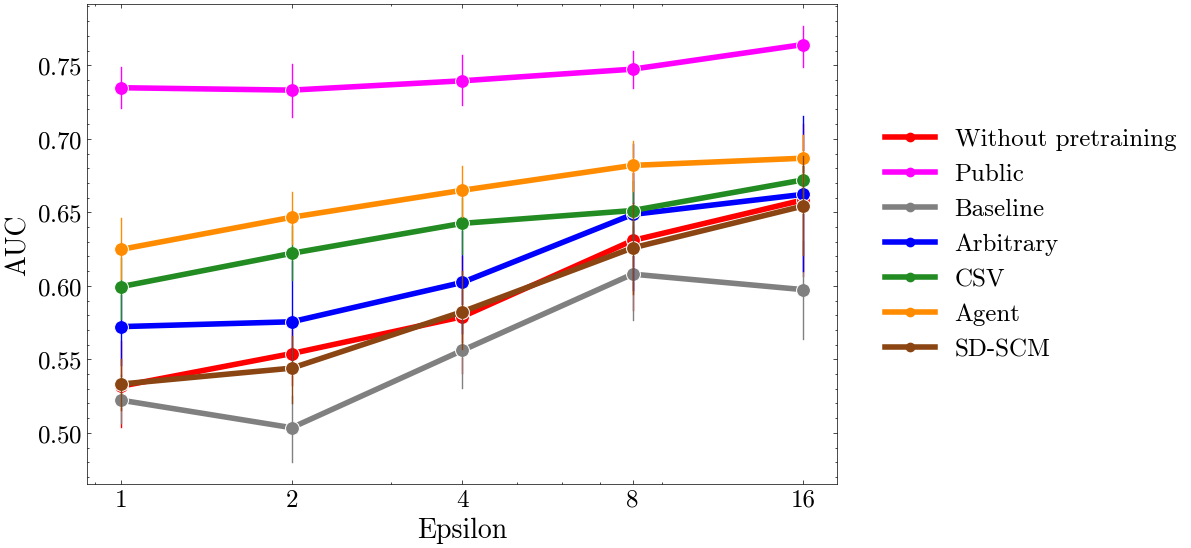

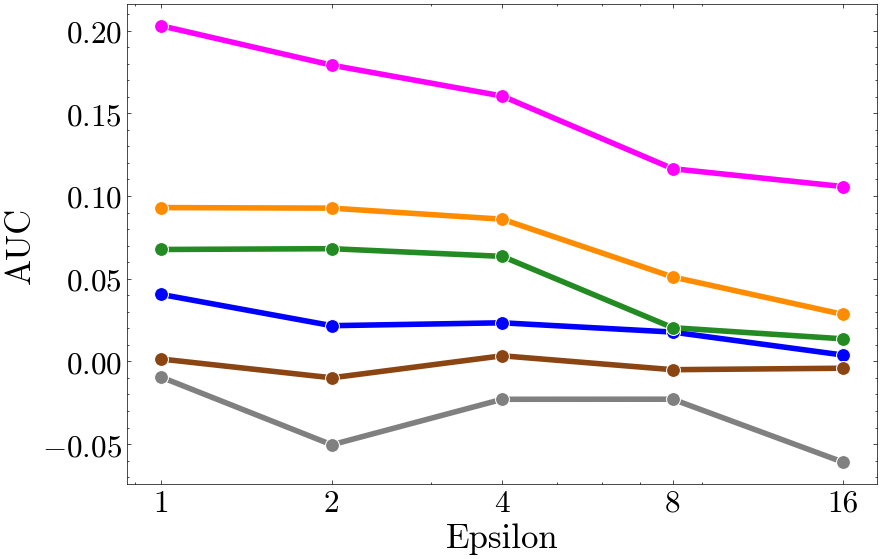

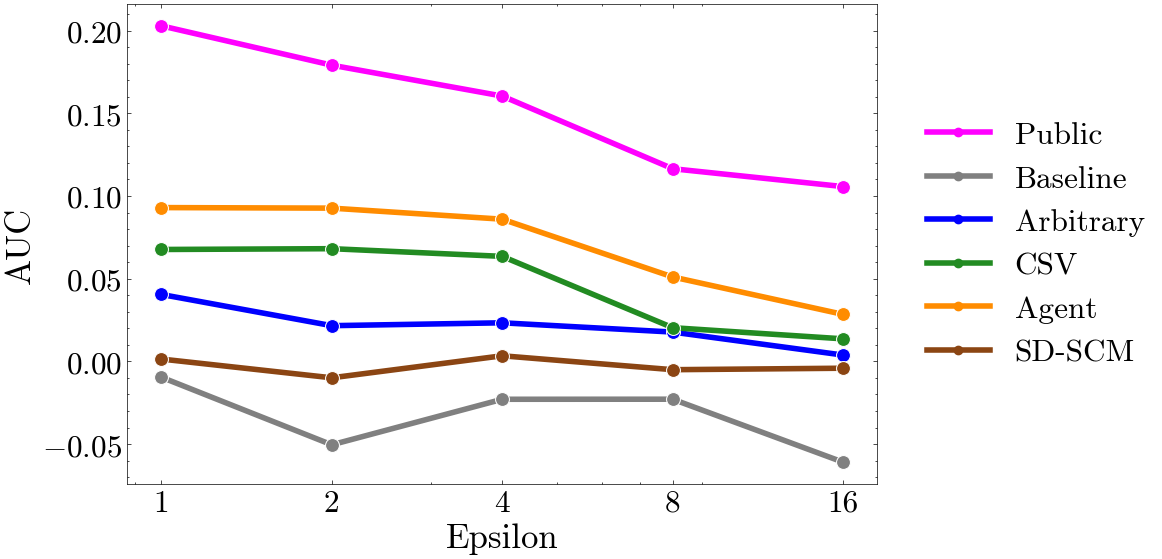

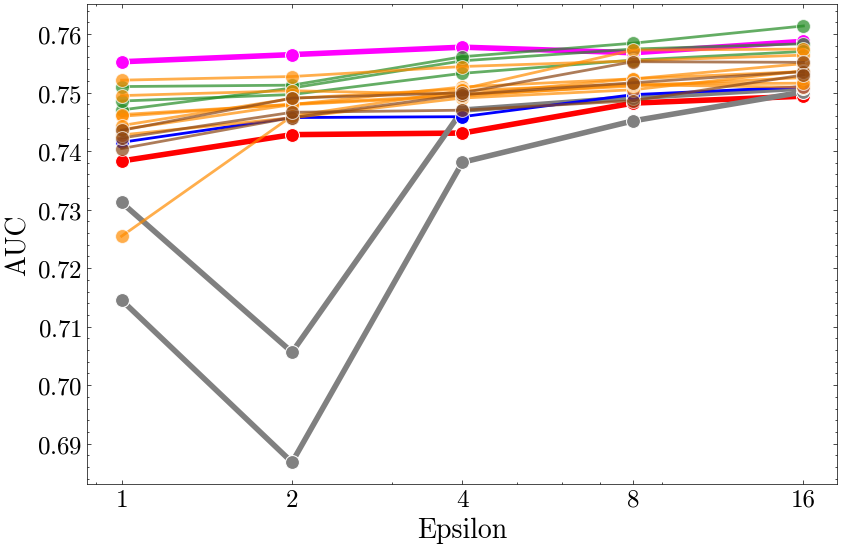

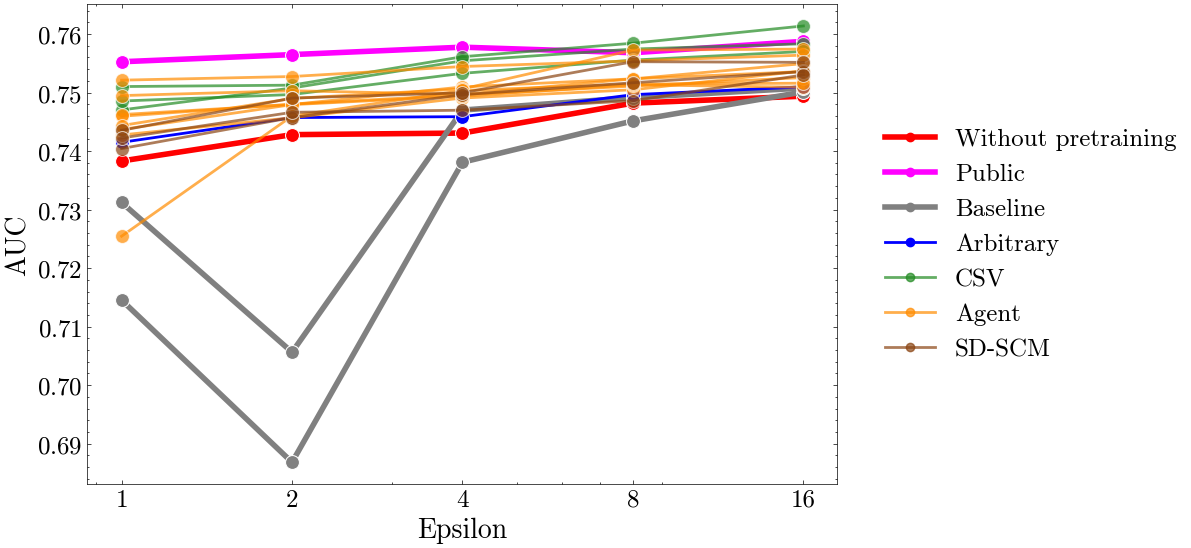

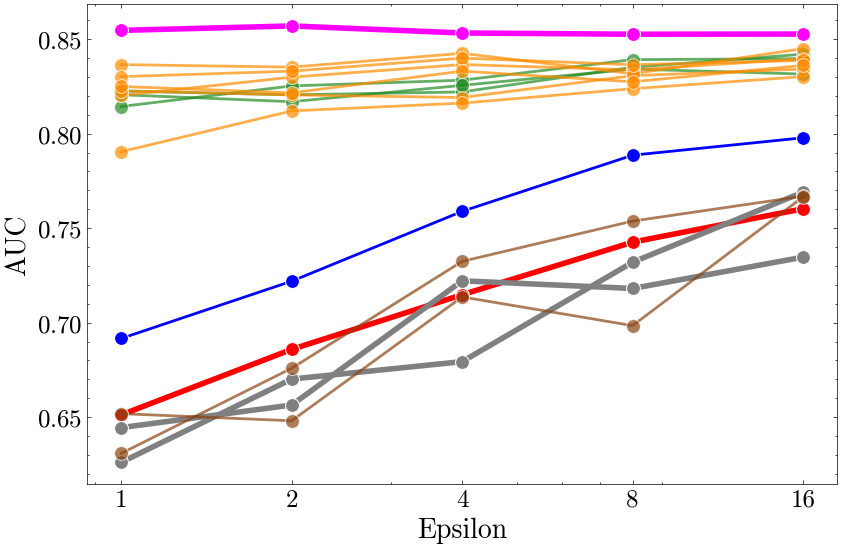

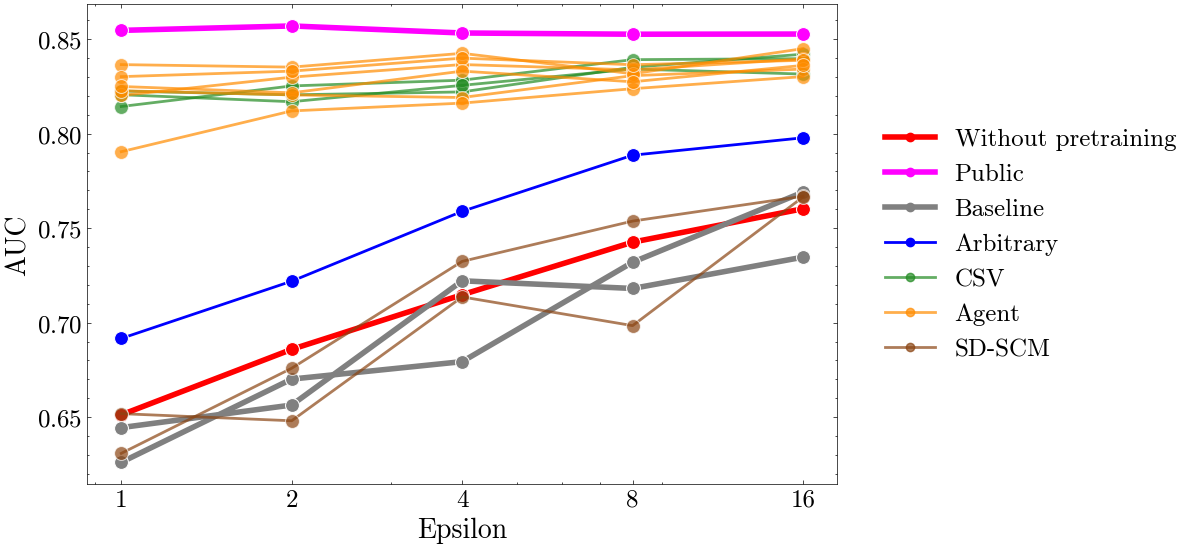

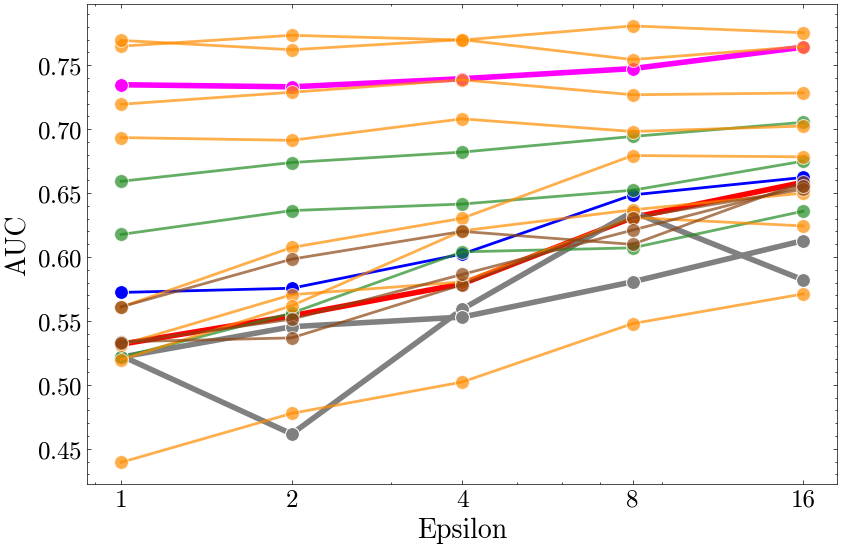

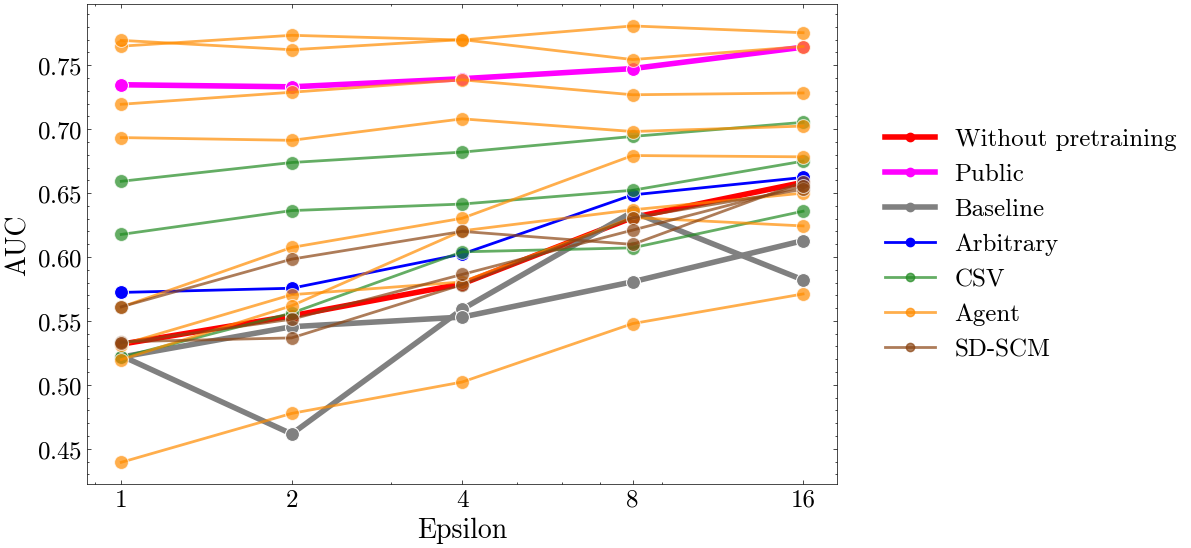

In [10]:
import warnings
warnings.filterwarnings("ignore")

for is_best in [False, True]:
    for viz_unit in ["category", "dataset"]:
        for datataset in ["acs", "edad", "we"]:

            if is_best:
                if viz_unit == "dataset":
                    df = runs_best_on_pre_df
                else :
                    df = runs_best_on_pre_without_gpt2_df
            else:
                if viz_unit == "dataset":
                    df = runs_df
                else:
                    df = runs_without_gpt2_df

            for is_adv in [False, True]:
                if is_adv and viz_unit == "dataset":
                    continue

                file_prefix = f"pretraining_{datataset}_{'adv' if is_adv else 'auc'}_{'best' if is_best else 'all'}_{viz_unit}"
                caption = create_caption(datataset, viz_unit, is_adv, is_best)

                for with_legend in [False, True]:

                    display(Markdown(f"### {datataset.upper()} Data{' (Advantage)' if is_adv else ''}{' (Best)' if is_best else ''}"))
                    fig, latex_table = plot_metrics(datataset, df,
                            viz_unit=viz_unit, is_adv=is_adv, with_legend=with_legend,
                            caption=caption)
                    display(fig)
                    display(Markdown(caption))
                    
                    fig.savefig(f"./plots/{file_prefix}_{'legend' if with_legend else 'no-legend'}.pdf", bbox_inches='tight')
                
                with open(f"./tables/{file_prefix}.tex", "w") as f:
                    f.write(latex_table)